# Proyecto 2. Entrega 2: Árboles de Decisión
### Integrantes
- Nelson García  
- Diego Linares
- Joaquin Puente
- José Mérida
- Joaquín Campos

Las secciones de análisis exploratorio y separación del modelo se realizaron en la entrega anterior, sin embargo consideramos importante tener esta información a la mano para poder referenciarla dentro de este mismo documento.

## Análisis exploratorio

In [291]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

### Carga de Datos y Revisión General

In [292]:
# estaremos definiendo ambos csvs para poder tener acceso a ambos pero usaremos el train y luego sobre el test replicaremos una vez se considere importante

# Definir NA como nuestros NaN
dftrain = pd.read_csv("train.csv", na_values=["NA"])

# incluimos en el analissi exploratorio lo basico para poder tenerlo a la mano
dftrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [293]:
# datos estadísticos básicos
dftrain.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [294]:
# tipos
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [295]:
# Revisamos posibles variables redundantes entre sí mismas
print(dftrain.nunique())

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64


### Separación de Columnas por Tipo de Variable
Algunas columnas cómo MSSubClass son categóricas nominales y cuentan con valores numéricos, además algunas otras columnas cómo pueden ser las de clasificación de estado son ordinales y tienen un encoding categórico (ej. Ex - Excelente en ExterCond). Es importante que clasifiquemos las diferentes variables para poder llevar a cabo el encoding de manera correcta y realizar nuestro análisis exploratorio. Tenemos 3 categorías:

- Ordinales
- Nominales
- Numéricas

Este proceso se lleva a cabo antes de depurar las columnas que no se utilizarán en el procesamiento de datos para evitar la necesidad de mantener en mente las columnas eliminadas al categorizar.

In [296]:
col_ordinales = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                 'BsmtExposure', 'HeatingQC',  'GarageQual', 'GarageCond', 'FireplaceQu',  'Functional',
                 'KitchenQual', 'PoolQC', 'Fence']
col_nominales = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
                 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
                 'GarageFinish','GarageType','PavedDrive', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
col_numericas = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']

Definimos una función para retornar el tipo de variable de cada columna

In [297]:
def get_type(col):
  if col in col_numericas + ['SalePrice']:
    return 'numerica'
  elif col in col_nominales:
    return 'nominal'
  elif col in col_ordinales:
    return 'ordinal'

Verificamos que todas las columnas se hayan ingresado correctamente

In [298]:
unassigned = []
for col in dftrain.columns:
  if get_type(col) == None:
    unassigned.append(col)

print(unassigned)

['Id']


### Datos Faltantes
En este paso vamos a analizar datos faltantes

Primero verificamos las columnas con valores nulos, para tener una mejor idea de que necesitamos hacer

In [299]:
missing_values = dftrain.isnull().sum() / len(dftrain) * 100
print(missing_values.sort_values(ascending=False))

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
                 ...    
ExterQual       0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
SalePrice       0.000000
Length: 81, dtype: float64


Nos damos cuenta que PoolQC tiene 99.5% de valores faltantes, ¿Por qué?

Algunas de las variables categóricas tienen cómo categoría "NA" y se toma como valor nulo al cargar los datos al DF. Creamos una lista con las variables que cuentan con esta característica

In [300]:
na_as_data_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                   'FireplaceQu', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence', 'MiscFeature',
                   'MasVnrType', 'GarageQual', 'GarageCond']

dftrain[na_as_data_cols] = dftrain[na_as_data_cols].fillna('Missing')

Revisando nuevamente las columnas con valores nulos

In [301]:
missing_values = dftrain.isnull().sum() / len(dftrain) * 100
print(missing_values.sort_values(ascending=False))

LotFrontage     17.739726
GarageYrBlt      5.547945
MasVnrArea       0.547945
Electrical       0.068493
KitchenAbvGr     0.000000
                  ...    
ExterQual        0.000000
MasVnrType       0.000000
Exterior2nd      0.000000
Exterior1st      0.000000
SalePrice        0.000000
Length: 81, dtype: float64


Ahora tenemos valores faltantes más manejables, primero vamos a tomar LotFrontage y GarageYrBlt y reemplazar los valores faltantes con la mediana. Esto debido a que el 17.73% y 5.54% siguen siendo cifras bastante significativas y no podemos simplemente eliminar estas filas.

In [302]:
cols_to_fill = ['LotFrontage', 'GarageYrBlt']

medians = dftrain[cols_to_fill].median()

dftrain[cols_to_fill] = dftrain[cols_to_fill].fillna(medians)

Revisando nuevamente los valores nulos

In [303]:
missing_values = dftrain.isnull().sum() / len(dftrain) * 100
print(missing_values.sort_values(ascending=False))

MasVnrArea      0.547945
Electrical      0.068493
GarageFinish    0.000000
GarageType      0.000000
FireplaceQu     0.000000
                  ...   
MasVnrType      0.000000
Exterior2nd     0.000000
Exterior1st     0.000000
RoofMatl        0.000000
SalePrice       0.000000
Length: 81, dtype: float64


Ahora con una pequeña cantidad de valores faltantes, podemos simplemente remover las filas que los contengan.

In [304]:
dftrain = dftrain.dropna()

missing_values = dftrain.isnull().sum() / len(dftrain) * 100
print(missing_values.sort_values(ascending=False))

Id             0.0
CentralAir     0.0
GarageYrBlt    0.0
GarageType     0.0
FireplaceQu    0.0
              ... 
MasVnrArea     0.0
MasVnrType     0.0
Exterior2nd    0.0
Exterior1st    0.0
SalePrice      0.0
Length: 81, dtype: float64


Ya no tenemos valores faltantes dentro de nuestro DF

### Encoding de Variables Categóricas
En este paso vamos a codificar las variables categóricas, las ordinales utilizando OrdinalEncoder y las nominales utilizando get_dummies. De esta manera podemos utilizar las variables ordinales cómo numéricas y aplicar las nominales a nuestro análisis.

Identificamos los diferentes valores que puedan tomar las variables dentro del dataset

In [305]:
for col in col_ordinales:
    print(f"{col}: {dftrain[col].unique()}")

OverallQual: [ 7  6  8  5  9  4 10  3  1  2]
OverallCond: [5 8 6 7 4 2 3 9 1]
ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
ExterCond: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual: ['Gd' 'TA' 'Ex' 'Missing' 'Fa']
BsmtCond: ['TA' 'Gd' 'Missing' 'Fa' 'Po']
BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'Missing']
HeatingQC: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
GarageQual: ['TA' 'Fa' 'Gd' 'Missing' 'Ex' 'Po']
GarageCond: ['TA' 'Fa' 'Missing' 'Gd' 'Po' 'Ex']
FireplaceQu: ['Missing' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Functional: ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']
PoolQC: ['Missing' 'Ex' 'Fa' 'Gd']
Fence: ['Missing' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


Aplicamos el encoding

In [306]:
# Diferentes categorías para las diferentes columnas
standard_categories = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'Missing']
fence_categories = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'Missing']
bsmt_exposure_categories = ['No', 'Mn', 'Av', 'Gd', 'Missing']
functional_categories = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Missing']

cleaned_ordinales = [x for x in col_ordinales if x not in ['OverallQual', 'OverallCond']]

# Limpiamos los entries quitando posibles errores de espacios
dftrain[cleaned_ordinales] = dftrain[cleaned_ordinales].astype(str).apply(lambda x: x.str.strip())

# Asignación de categorías a columnas
categories = []
for col in cleaned_ordinales:
    if col == 'Fence':
        categories.append(fence_categories)
    elif col == 'BsmtExposure':
        categories.append(bsmt_exposure_categories)
    elif col == 'Functional':
        categories.append(functional_categories)
    else:
        categories.append(standard_categories)

# Inicialización y aplicación de encoder
encoder = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)
dftrain[cleaned_ordinales] = encoder.fit_transform(dftrain[cleaned_ordinales]).astype(int)

# Verificacion de filas sin encodear
print((dftrain[cleaned_ordinales] == -1).sum())

# Conteo de valores por cada columna
for col in cleaned_ordinales:
    print(f"{col}:")
    print("\n".join([f"{val} - {count}" for val, count in dftrain[col].value_counts().items()]))
    print()


ExterQual       0
ExterCond       0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
HeatingQC       0
GarageQual      0
GarageCond      0
FireplaceQu     0
Functional      0
KitchenQual     0
PoolQC          0
Fence           0
dtype: int64
ExterQual:
2 - 905
1 - 481
0 - 51
3 - 14

ExterCond:
2 - 1273
1 - 146
3 - 28
0 - 3
4 - 1

BsmtQual:
2 - 648
1 - 611
0 - 120
5 - 37
3 - 35

BsmtCond:
2 - 1303
1 - 64
3 - 45
5 - 37
4 - 2

BsmtExposure:
0 - 945
2 - 221
3 - 133
1 - 114
4 - 38

HeatingQC:
0 - 734
2 - 427
1 - 240
3 - 49
4 - 1

GarageQual:
2 - 1302
5 - 81
3 - 48
1 - 14
0 - 3
4 - 3

GarageCond:
2 - 1317
5 - 81
3 - 35
1 - 9
4 - 7
0 - 2

FireplaceQu:
5 - 685
1 - 378
2 - 311
3 - 33
0 - 24
4 - 20

Functional:
0 - 1352
2 - 34
1 - 31
3 - 15
4 - 13
5 - 5
6 - 1

KitchenQual:
2 - 734
1 - 579
0 - 99
3 - 39

PoolQC:
5 - 1444
1 - 3
0 - 2
3 - 2

Fence:
4 - 1170
1 - 157
0 - 59
2 - 54
3 - 11



<ipython-input-306-d6c072b0ab8c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain[cleaned_ordinales] = dftrain[cleaned_ordinales].astype(str).apply(lambda x: x.str.strip())
<ipython-input-306-d6c072b0ab8c>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain[cleaned_ordinales] = encoder.fit_transform(dftrain[cleaned_ordinales]).astype(int)


Para las variables nominales, utilizamos get_dummies.

In [307]:
dftrain = pd.get_dummies(dftrain, columns=col_nominales, prefix_sep='_')
dftrain

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,1,2,...,False,False,False,True,False,False,False,False,True,False
1,2,80.0,9600,6,8,1976,1976,0.0,2,2,...,False,False,False,True,False,False,False,False,True,False
2,3,68.0,11250,7,5,2001,2002,162.0,1,2,...,False,False,False,True,False,False,False,False,True,False
3,4,60.0,9550,7,5,1915,1970,0.0,2,2,...,False,False,False,True,True,False,False,False,False,False
4,5,84.0,14260,8,5,2000,2000,350.0,1,2,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,6,5,1999,2000,0.0,2,2,...,False,False,False,True,False,False,False,False,True,False
1456,1457,85.0,13175,6,6,1978,1988,119.0,2,2,...,False,False,False,True,False,False,False,False,True,False
1457,1458,66.0,9042,7,9,1941,2006,0.0,0,1,...,False,False,False,True,False,False,False,False,True,False
1458,1459,68.0,9717,5,6,1950,1996,0.0,2,2,...,False,False,False,True,False,False,False,False,True,False


Con el output podemos observar que ya se encuentran codificadas nuestras variables categóricas ordinales utilizando valores numéricos.

### Depuración de Datos
En este paso revisamos si existen datos duplicados

Eliminación de Filas Duplicadas

In [308]:
before = dftrain.shape[0]

# Eliminar duplicados
dftrain = dftrain.drop_duplicates()
after = dftrain.shape[0]
print(f"Filas eliminadas: {before - after}")

Filas eliminadas: 0


No existen filas duplicadas.

dftrain.drop('id', axis=2, inplace=True)

### Exploración Variable de Respuesta
En este paso buscamos obtener más información sobre la variable respuesta, ya que nuestro interés es buscar predecirla.

¿Cómo se distribuye?

[Text(0.5, 1.0, 'Distribucion de SalePrice'),
 Text(0.5, 0, 'Precio de Venta'),
 Text(0, 0.5, 'Cantidad de Casas')]

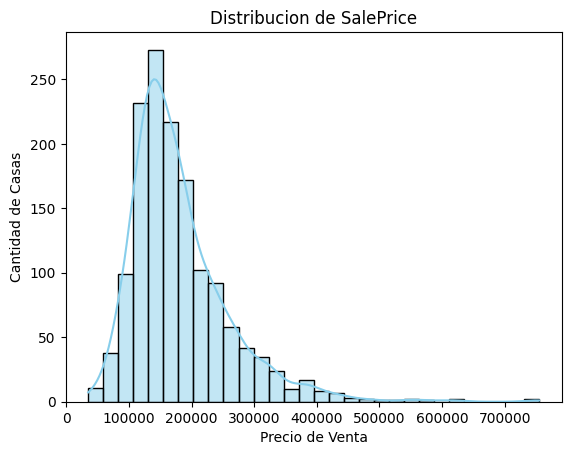

In [309]:
sns.histplot(dftrain['SalePrice'], kde=True, color='skyblue', bins=30).set(title='Distribucion de SalePrice', xlabel='Precio de Venta', ylabel='Cantidad de Casas')

La variable SalePrice sigue una distribución cerca de la normal, con un sesgo hacia la derecha. Esto quiere decir que hay más casas con precios bajos a medios y pocas con precios muy altos. A parte del análisis gráfico, podemos obtener algunos datos adicionales

In [310]:
print(dftrain['SalePrice'].describe())
print("Skewness:", dftrain['SalePrice'].skew())

count      1451.000000
mean     180624.101999
std       79312.128273
min       34900.000000
25%      129900.000000
50%      162500.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.8831110462405252


¿Cuáles variables se correlacionan con la variable objetivo?

In [311]:
# cuántas categorías únicas hay por columna?
print(dftrain.select_dtypes(include=['object']).nunique())

print("Distribucion de categorias por columna: ")
# Distribución de categorías por columna
for col in dftrain.select_dtypes(include=['object']).columns:
    print(dftrain[col].value_counts())

Series([], dtype: float64)
Distribucion de categorias por columna: 


Gracias a este output podemos "observar" de forma rápida, que algunas de las variables como utilities, un poco LandSlope, Condition2 y tal vez otras variables pueden ser eliminadas, pero necesitamos poder justificar, de esta forma igual ya nos podemos hacer una idea de como hay algunas variables que tienen poca relevancia.

### Exploración Variables Categóricas Ordinales
En este paso buscamos obtener más información sobre las variables categóricas ordinales, buscando identificar cómo se distribuyen y que nos dicen sobre las casas del dataset

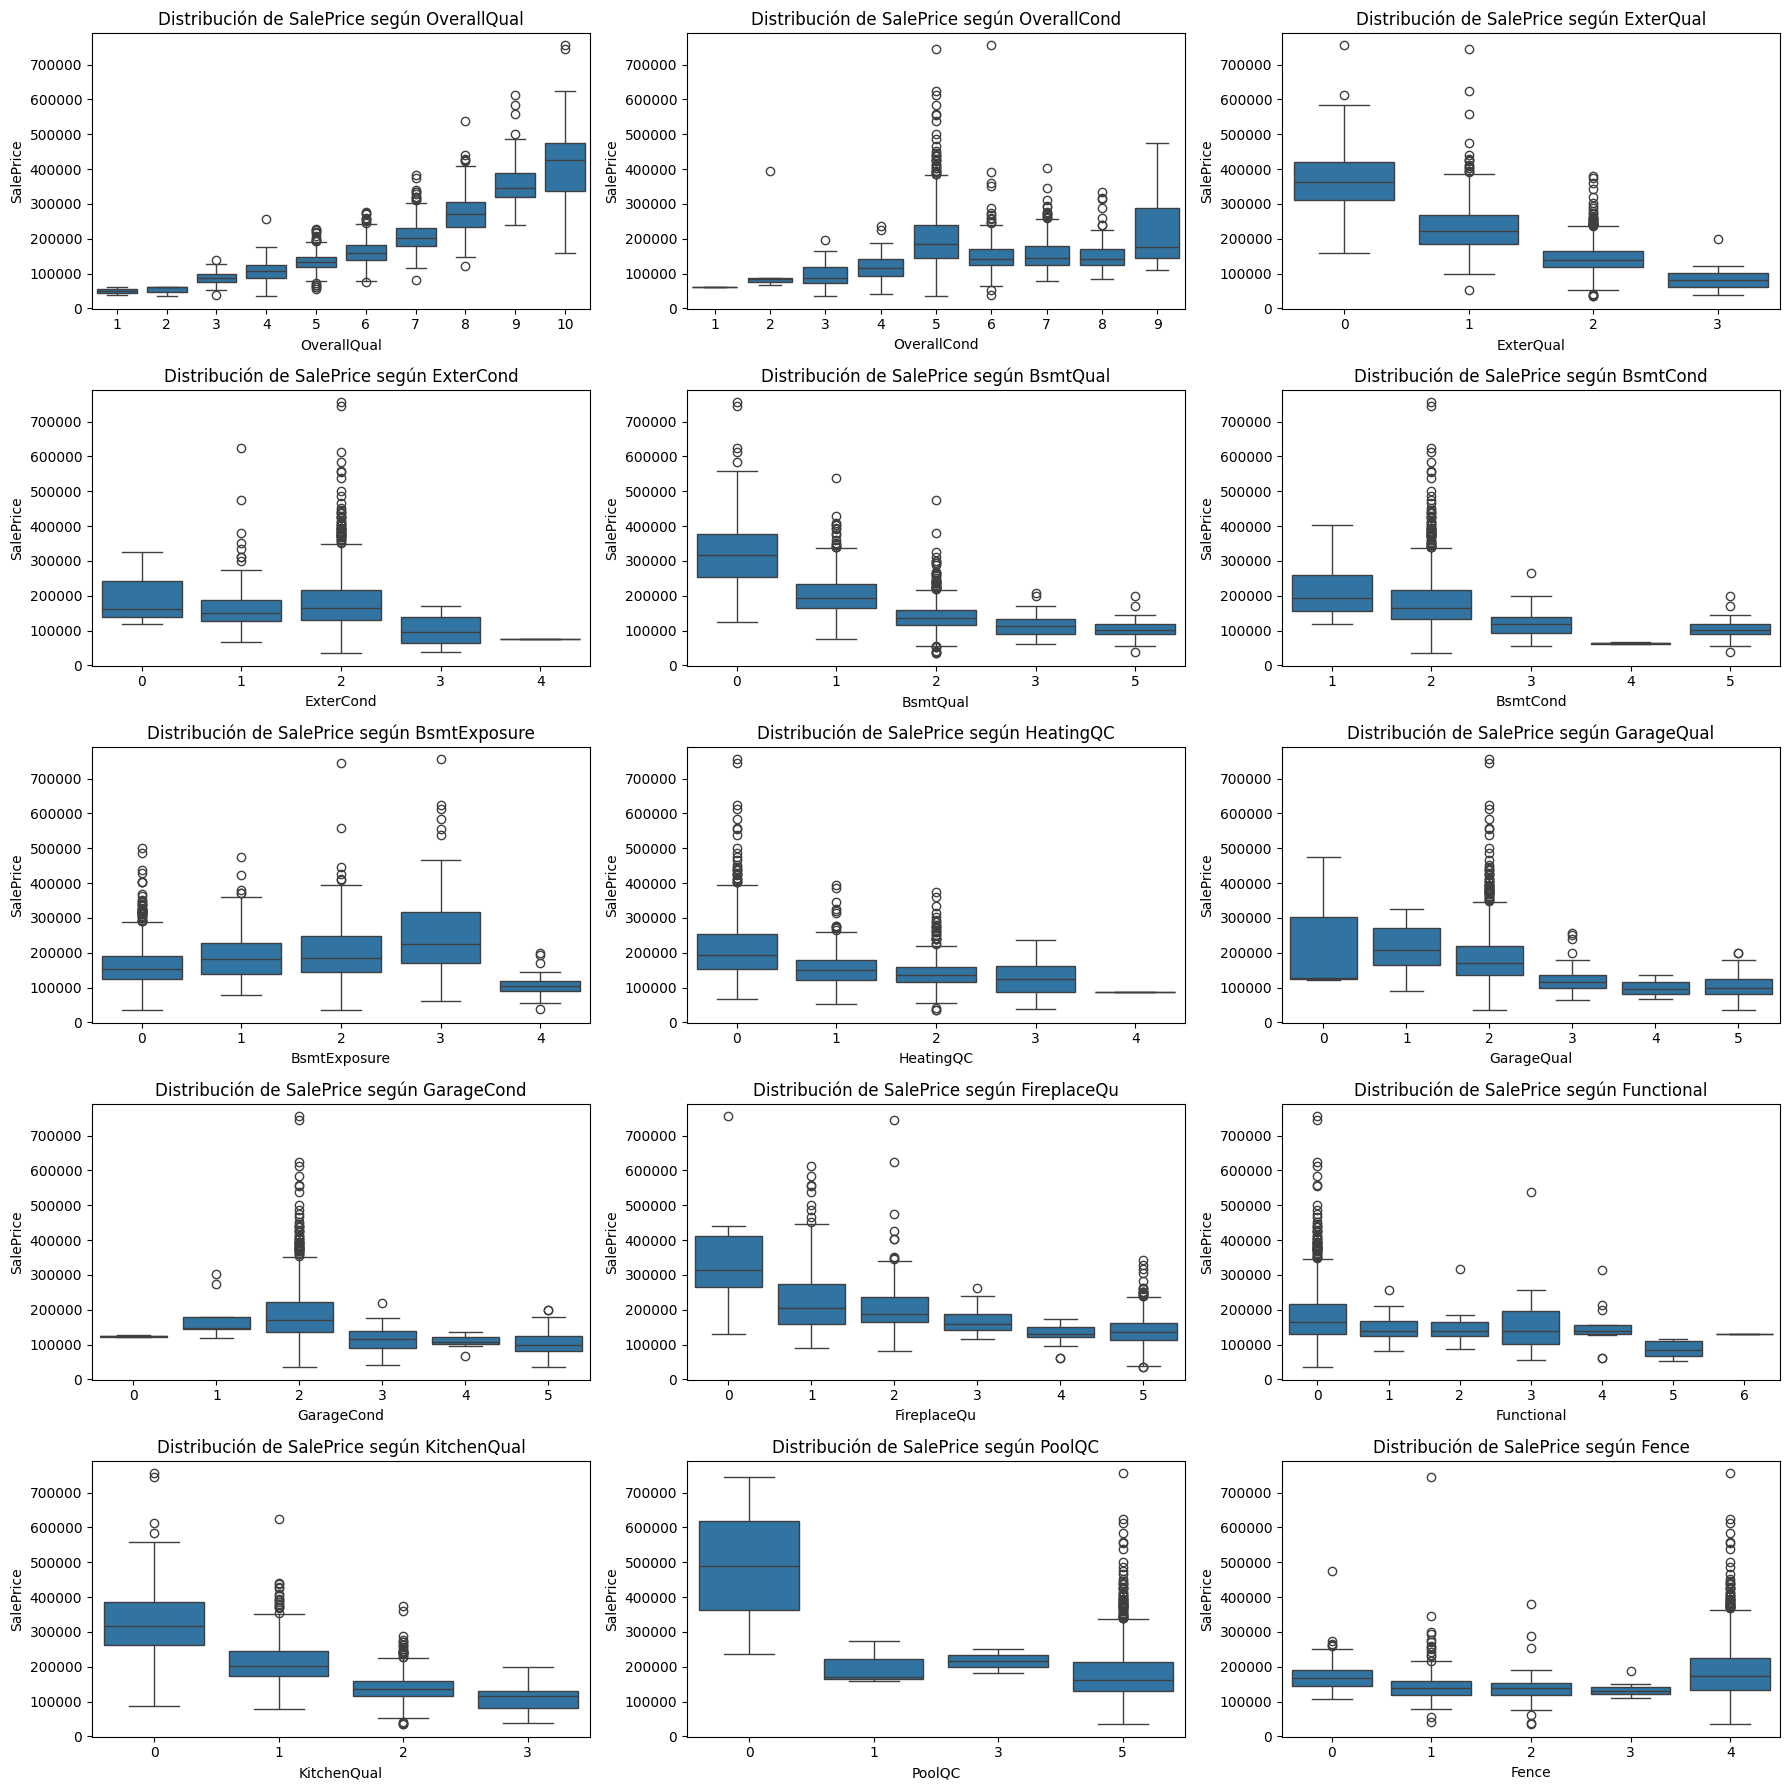

In [312]:
# Generar gráficos para cada variable ordinal con respecto a SalePrice
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(col_ordinales):
    if col in dftrain.columns and dftrain[col].nunique() > 1:
        sns.boxplot(data=dftrain, x=col, y="SalePrice", ax=axes[i])
        axes[i].set_title(f"Distribución de SalePrice según {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("SalePrice")
    else:
        axes[i].axis('off')  # Ocultar gráficos vacíos

plt.tight_layout()
plt.show()


Con base en la información que nos presentan los gráficos anteriores

Podemos concluir que
- La calidad general (OverallQual) es el factor ordinal más importante para determinar SalePrice.
- Las características internas como KitchenQual y FireplaceQu tienen un fuerte impacto en el valor de la vivienda.
- Condiciones estructurales (OverallCond, Functional) tienen menos influencia.
- Elementos adicionales como piscinas pueden elevar significativamente el precio, pero su presencia es rara.

### Exploración Variables Categóricas Nominales

<ipython-input-313-7b4e55ae9ea6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')


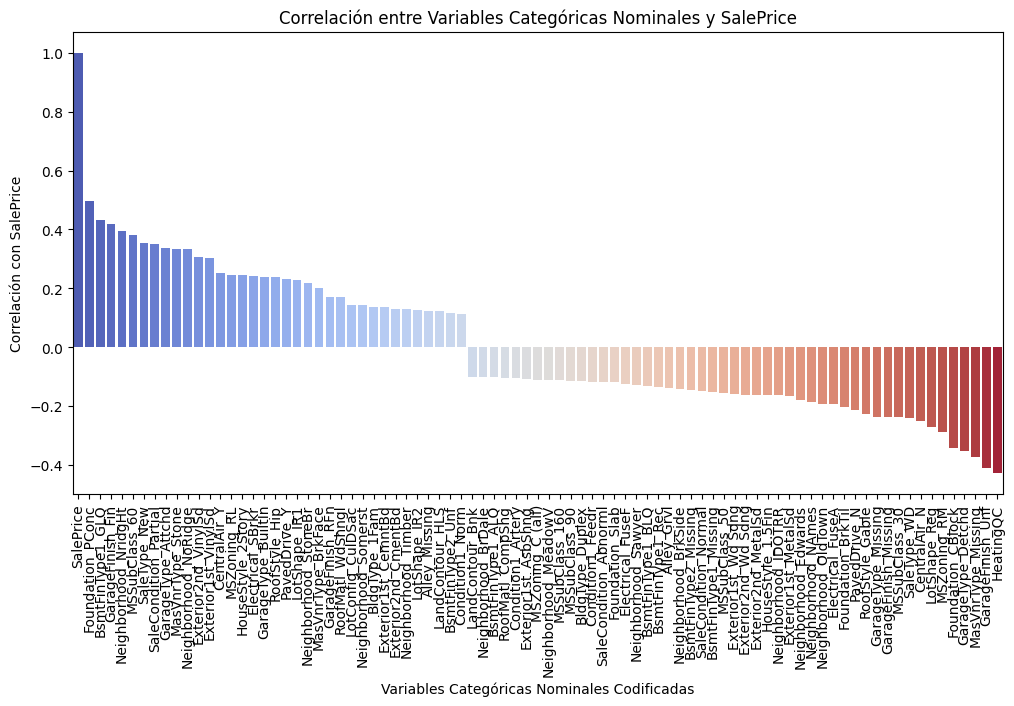

In [313]:
# Seleccionar solo las columnas codificadas
encoded_cols = [col for col in dftrain.columns if any(col.startswith(nom) for nom in col_nominales)]

# Calcular la correlación de las variables categóricas nominales con SalePrice
correlations = dftrain[encoded_cols + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)

# Graficar las correlaciones más significativas
correlations = correlations.dropna()
correlations = correlations[correlations.abs() > 0.1]  # Filtrar solo las más relevantes

plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.xlabel("Variables Categóricas Nominales Codificadas")
plt.ylabel("Correlación con SalePrice")
plt.title("Correlación entre Variables Categóricas Nominales y SalePrice")
plt.show()


Con base en la gráfica anterior, podemos observar que

- Ubicación (Neighborhood) es uno de los factores más determinantes en el precio de venta, se menciona por todos los campos que incluyen a (Neighborhood)
- La calidad del cimiento (Foundation), el sótano (BsmtFinType1), el acabado del garaje (GarageFinish) y el tipo de vivienda también influyen significativamente.
- Ciertas configuraciones como garajes separados o sistemas de calefacción deficientes pueden reducir el valor.
- Algunas variables nominales, aunque intuitivamente importantes, tienen una baja correlación y pueden no ser determinantes.

### Exploracion Variables Numéricas

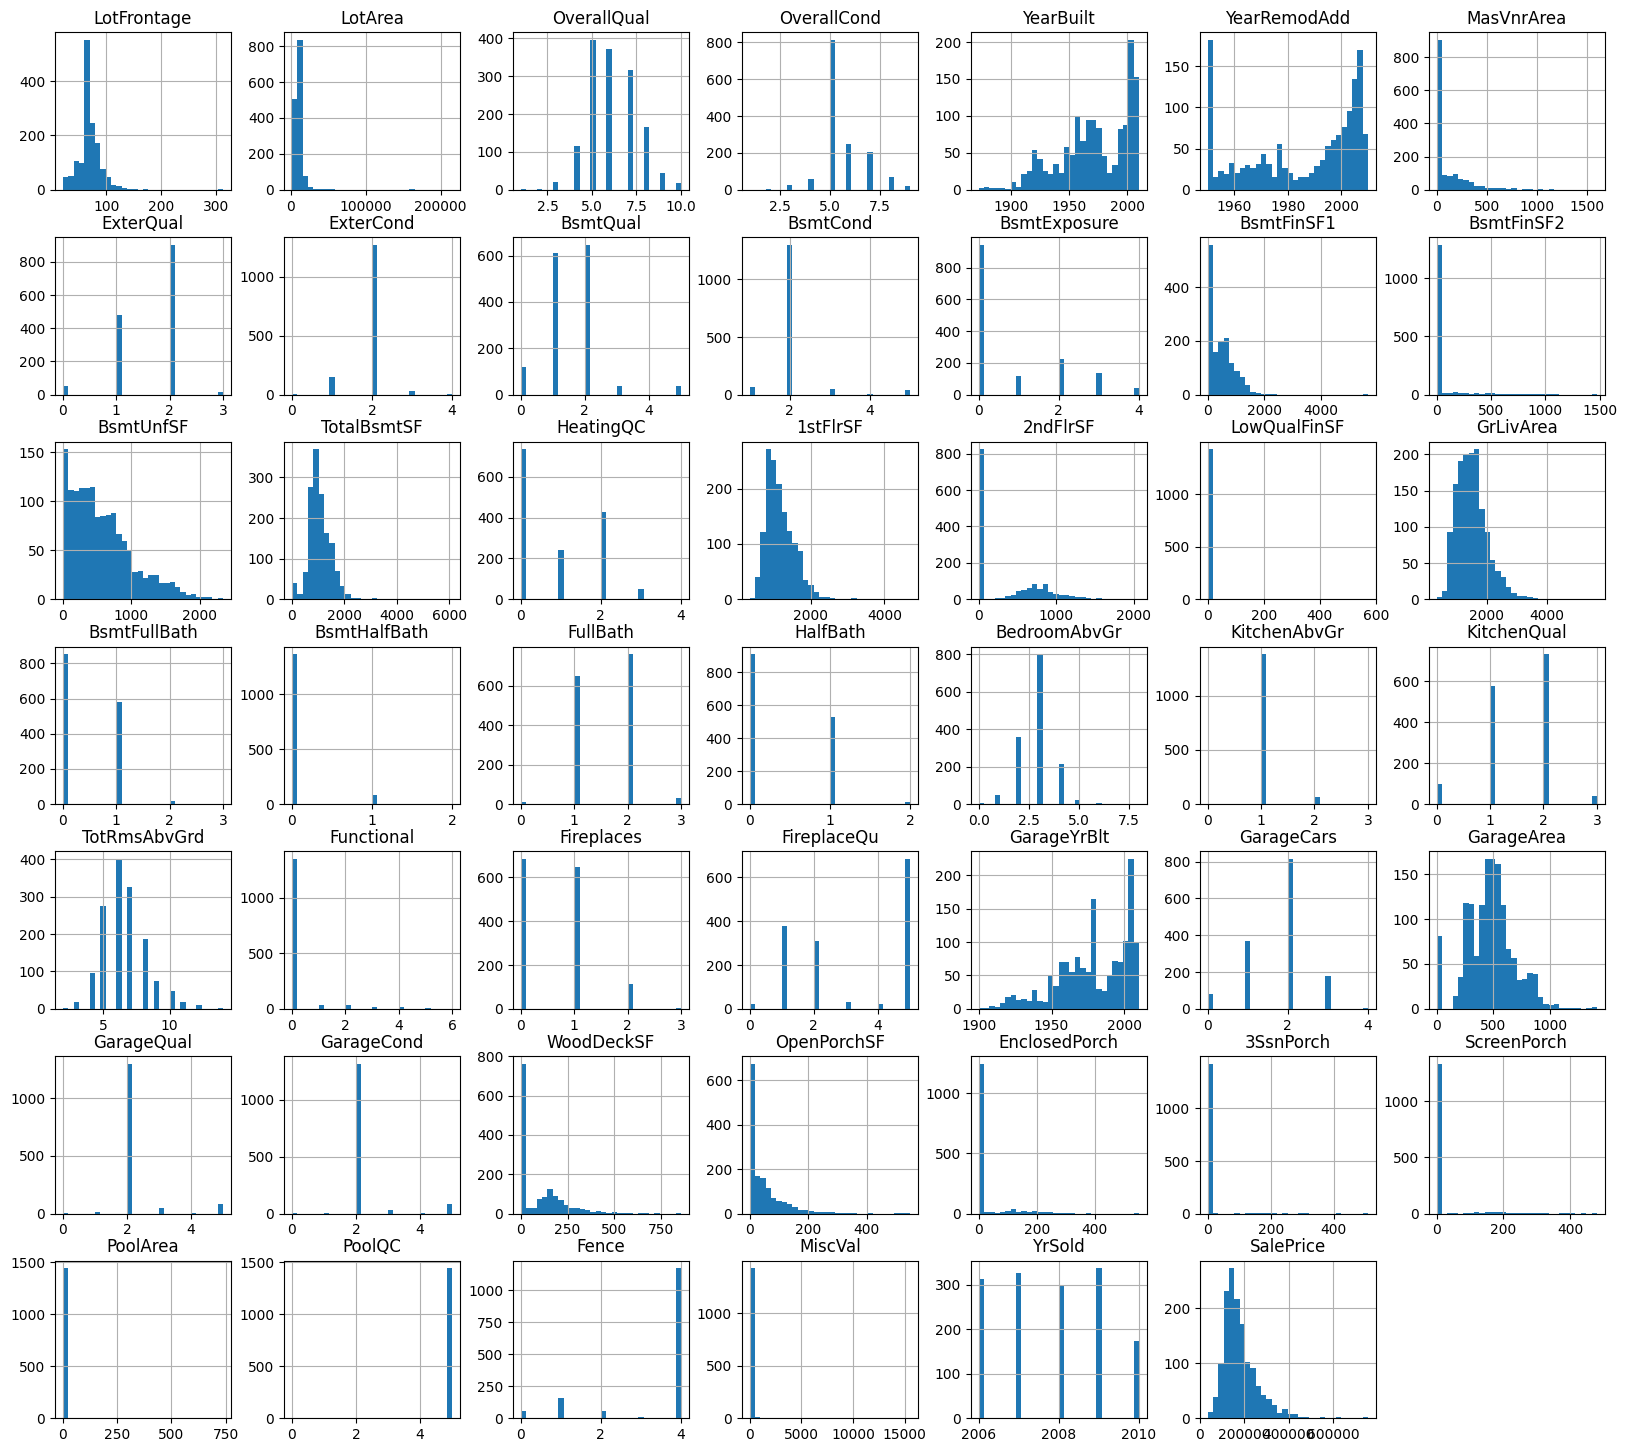

In [314]:
df_num = dftrain.select_dtypes(include = ['float64', 'int64'])
df_num = df_num.drop('Id', axis=1)
# Visualizacion y observacion variables numericas
df_num.hist(figsize=(20, 18), bins=30)
plt.show()

Gracias a esto podemos imaginar que hay bastantes variables con nulas, o como wooddeckSF en donde parece que la varianza es baja podemos identificar tambien que ademas hay bastantes varaibles que pueden sernos de gran utilidad en la busqueda de salesPrice pero sobre todo variables que tienden a una moda y como estas distribuciones que podriamos usar.

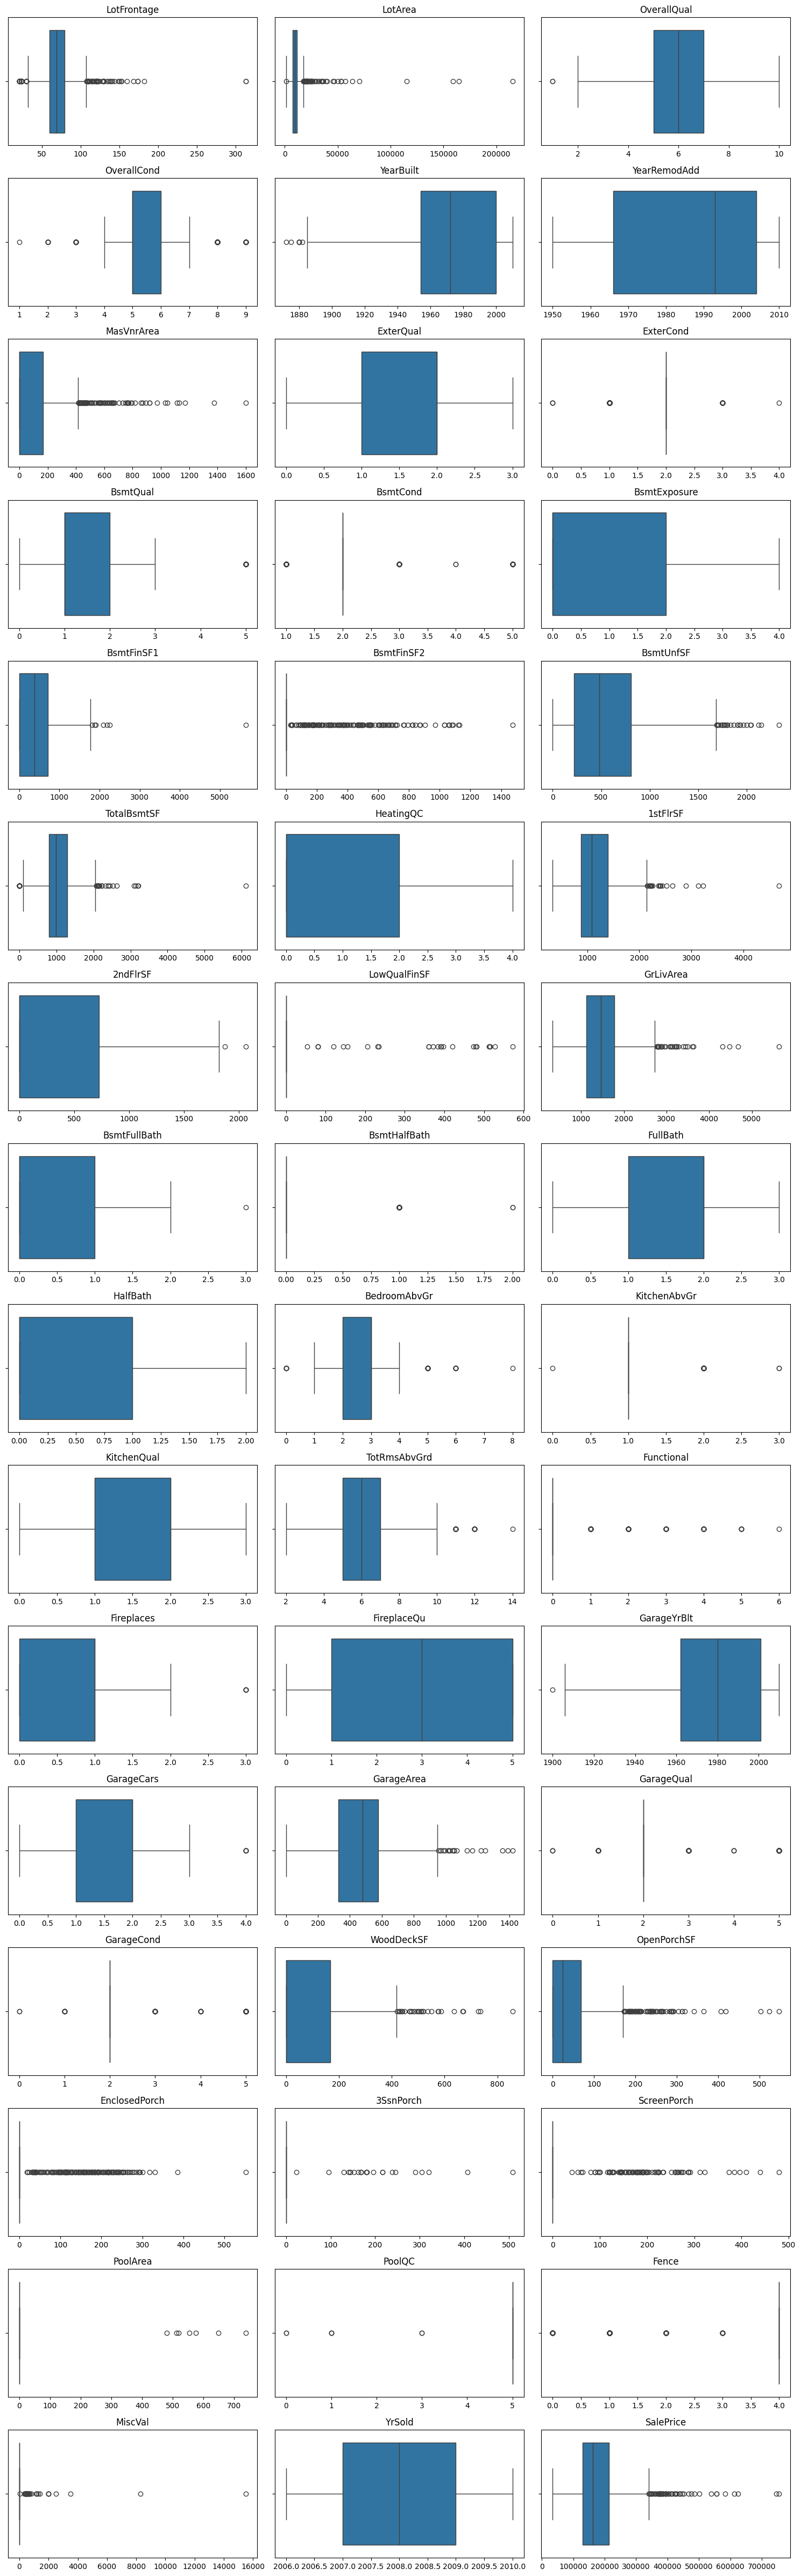

In [315]:
# Crear un solo gráfico con subplots
num_cols = len(df_num.columns)
ncols = 3
nrows = (num_cols // ncols) + (num_cols % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

for i, col in enumerate(df_num.columns):
    sns.boxplot(x=df_num[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("")

# Ocultar gráficos vacíos si hay menos columnas que subplots
total_axes = len(axes)
for i in range(num_cols, total_axes):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Segun esto podemos ver que la correlacion entre las variables númericas pero aún asi no podemos descartar ninguna variable porque la correlacion no tienen numeros altos para poder eliminarla con justificacion.

## Separación del modelo (Inciso 1)

Gracias a ambos analisis, podemos determinar que la variable con mas relacion a SalePrice, es OverallQual, de esta forma para hacer la particion del subconjunto de prueba y entrenamiento, podemos ayudarnos de esta.

Se usará la particion 80/20 de manera que el 80% del dataset(train.csv) se usará para entrenamiento, y el 20% del dataset(train.csv) se usara para prueba.

In [316]:
train_set_strat, test_set_strat = train_test_split(
    dftrain,
    test_size=0.2,
    stratify=dftrain["OverallQual"],
    random_state=42  #Asegura reproducibilidad
)

print("Tamaño de train:", train_set_strat.shape[0])
print("Tamaño de test:", test_set_strat.shape[0])

train_distribution = train_set_strat["OverallQual"].value_counts(normalize=True).sort_index()
test_distribution = test_set_strat["OverallQual"].value_counts(normalize=True).sort_index()

distribution_df = pd.DataFrame({
    "OverallQual": train_distribution.index,
    "Train Proportion": train_distribution,
    "Test Proportion": test_distribution.reindex(train_distribution.index, fill_value=0)
}).reset_index(drop=True)

print(distribution_df)

Tamaño de train: 1160
Tamaño de test: 291
   OverallQual  Train Proportion  Test Proportion
0            1          0.001724         0.000000
1            2          0.001724         0.003436
2            3          0.013793         0.013746
3            4          0.080172         0.079038
4            5          0.273276         0.271478
5            6          0.256034         0.257732
6            7          0.217241         0.216495
7            8          0.114655         0.116838
8            9          0.029310         0.030928
9           10          0.012069         0.010309


## Árbol de Regresión (Sin Max Depth) (Incisos 2, 3)
En esta sección implementamos un árbol de regresión para predecir el precio de las casas utilizando todas las variables. Se utiliza para predecir el precio de las casas y se analiza el rendimiento

### Entrenamiento del Arbol
En esta sección separamos los splits X e Y de entrenamiento y prueba, utilizando el DecisionTreeRegressor de SKLearn para entrenar nuestro modelo

Separación de splits

In [317]:
X_train = train_set_strat.drop(columns=['SalePrice'])
Y_train = train_set_strat['SalePrice']

X_test = test_set_strat.drop(columns=['SalePrice'])
Y_test = test_set_strat['SalePrice']

Entrenamiento del árbol de regresión

In [318]:
regressor = DecisionTreeRegressor(random_state = 42)

regressor.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=42)

### Predicciones
En esta sección aplicamos nuestra regresión a ambos conjuntos, el conjunto de prueba y el conjunto de entrenamiento. Esto con la finalidad de determinar el rendimiento de nuestro modelo y poder determinar si existe overfitting al utilizar todas las variables disponibles.

In [319]:
Y_pred = regressor.predict(X_test)
Y_train_pred = regressor.predict(X_train)

### Análisis
En esta sección indagamos sobre los indicadores y gráficas necesarias para determinar y explicar el rendimiento de nuestro modelo.

***Análisis MSE, MAE y R²***

In [320]:
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Test")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

mse = mean_squared_error(Y_train, Y_train_pred)
mae = mean_absolute_error(Y_train, Y_train_pred)
r2 = r2_score(Y_train, Y_train_pred)

print("Train")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Test
Mean Squared Error (MSE): 1906093576.1786942
Mean Absolute Error (MAE): 27635.800687285224
R-squared (R²): 0.7112249630873624
Train
Mean Squared Error (MSE): 0.0
Mean Absolute Error (MAE): 0.0
R-squared (R²): 1.0


**Rendimiento en Entrenamiento**
- R²: 1.0
- MSE: 0.0
- MAE: 0.0

**Rendimiento en Prueba**
- R²: 0.71
- MSE: 1906093576.18
- MAE: 27635.80


_R² de 1.0 en el set de entrenamiento, ¿El modelo perfecto?_

No, el rendimiento en el entrenamiento sugiere un performance completamente perfecto. Esto lo que indica, es que el modelo se adaptó **demasiado** bien al conjunto de entrenamiento y se memorizó todo el ruido y los datos atípicos presentes dentro de este split. Lo que se busca dentro del modelo es que se encuentren patrones generalizables para poder predecir correctamente otros sets de datos.

_Rendimiento de Prueba_

Al analizar las estadísticas en el conjunto de prueba, nos damos cuenta que efectivamente si hay overfitting. La diferencia en rendimiento es bastante significativa, por lo que la adapción tan cercana al conjunto de entrenamiento prueba ser contraproducente.

_Posibles Causas_

Es bastante común que los árboles de regresión sufran de overfitting. Además, por default el DecisionTreeRegressor en scikit-learn no limita la profundidad del árbol. Eso aumenta el overfitting, ya que este árbol seguirá creciendo hasta que llegue a ajustarse completamente a los datos de entrenamiento.

_Ajustes_

Una manera que se pueden explorar ajustes en el modelo es modificar el parámetro de profundidad. Esto previene que el árbol siga creciendo indefinidamente sobre-ajustándose a los datos de prueba y busque predecir de manera perfecta cada dato atípico o particularidad de los datos.


***Información Sobre el Árbol***

Debido a la profundidad del árbol, resulta sumamente complicado graficarlo y llegar a conclusiones basados en la gráfica. Debido a esto, decidimos obtener diferentes características del árbol y analizarlo de esa manera

In [321]:
print(f"Profundidad: {regressor.tree_.max_depth}")
print(f"Numero de Hojas: {regressor.get_n_leaves()}")
print(f"Samples Promedio por Hoja: {np.mean(regressor.tree_.n_node_samples[np.where(regressor.tree_.children_left == regressor.tree_.children_right)[0]]):.2f}")
print(f"Hoja con Más Samples: {np.max(regressor.tree_.n_node_samples[np.where(regressor.tree_.children_left == regressor.tree_.children_right)[0]])}")
print(f"Cantidad de Datos de Entrenamiento:  {len(train_set_strat)}")

Profundidad: 26
Numero de Hojas: 1112
Samples Promedio por Hoja: 1.04
Hoja con Más Samples: 3
Cantidad de Datos de Entrenamiento:  1160


Los datos obtenidos respaldan nuestro análisis anterior, explicando la existencia del over-fitting. ¿Por qué?

*Profundidad: 26*

Esto nos indica que hay 26 niveles diferentes dónde se separan los datos, lo cuál es una profundidad bastante alta para el árbol.

*Número de Hojas: 1112*

Estos son los nodos dónde "terminan" los datos para predecir su precio, teniendo 1160 datos y 1112 hojas indica que existe un nodo específico para cada uno de los datos casi todas las veces. Esto nos lleva a cumplir condiciones **sumamente específicas** para llegar a cada uno, adaptándose muy bien a los datos de entrenamiento pero talvez no a los de prueba.

*Samples Promedio por Hoja: 1.04*

Respaldando el análisis del inciso anterior, la cantidad de nodos por hoja es sumamente baja. Esto quiere decir que el árbol esta prediciendo específicamente cada uno de los datos, en vez de buscar patrones más generalizables que puedan categorizar datos nuevos.

*Hoja con Más Samples: 3*

El 'grupo' más grande dentro del grupo de entrenamiento del árbol fue de 3 samples, el modelo no logró reconocer alguna otra similaridad entre los datos

*Conclusiones*

La profundidad y la forma del árbol explica el overfitting descrito en el análisis de eficiencia del modelo. Además, apoya la sugerencia de variar el parámetro de profundidad para llegar a un modelo que tenga la capacidad de reconocer patrones generales y no específicos del set de entrenamiento.

***Gráficas***

**Valores Reales vs Predicciones**

Buscamos analizar de manera gráfica los valores reales en comparación de los predecidos por el modelo

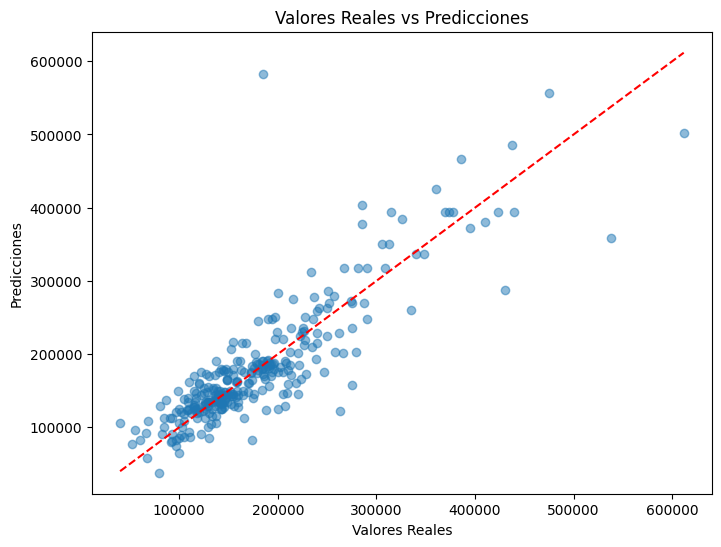

In [322]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.show()

En la gráfica podemos observar lo siguiente:

- Los puntos parecen estar distribuidos bastante uniformemente entre estar por encima y por abajo de la línea roja. Esto indica que no hay un over / under prediction significativo

- Los valores pequeños se encuentran bastante cercanos a la línea, sin embargo mientras esta crece se van alejando más. Indicando que los errores crecen para valores más altos. Esto puede darse debido a la alta diferencia entre valores (100,000 vs 600,000) o errores dentro del modelo.

- Existen algunos valores atípicos bastante alejados de los demás puntos, esto se puede dar debido a la inhabilidad del modelo de encontrar algunos patrones más complejos. O bien, debido al over-fitting.

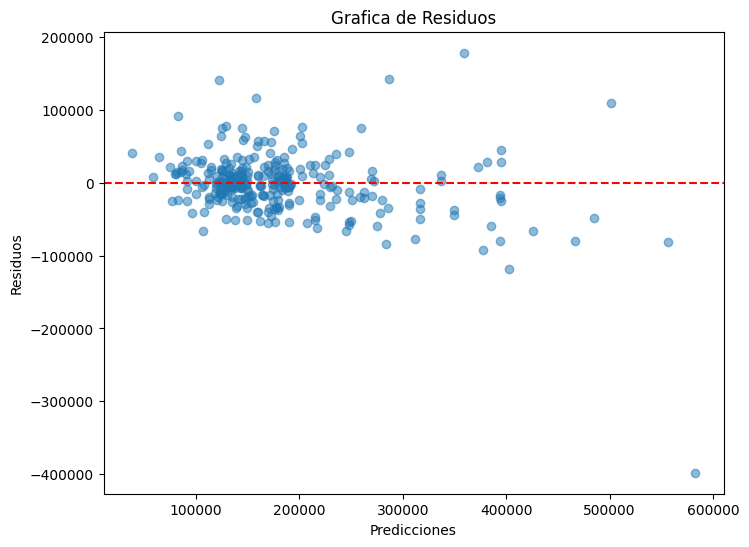

In [323]:
residuals = Y_test - Y_pred

plt.figure(figsize=(8, 6))
plt.scatter(Y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Grafica de Residuos")
plt.show()

La gráfica de residuos nos indica que la precisión del modelo decrece conforme el valor de la propiedad aumenta. Esta información se puede utilizar para variar los parámetros del árbol, o transformar variables de manera que se ajusten de mejor manera a la regresión.

10 Features mas importantes:
          Feature  Importance
3     OverallQual    0.642788
21      GrLivArea    0.100170
19       2ndFlrSF    0.050509
16    TotalBsmtSF    0.036756
13     BsmtFinSF1    0.025582
34     GarageCars    0.025027
35     GarageArea    0.010805
6    YearRemodAdd    0.008858
38     WoodDeckSF    0.006182
221  CentralAir_N    0.005905


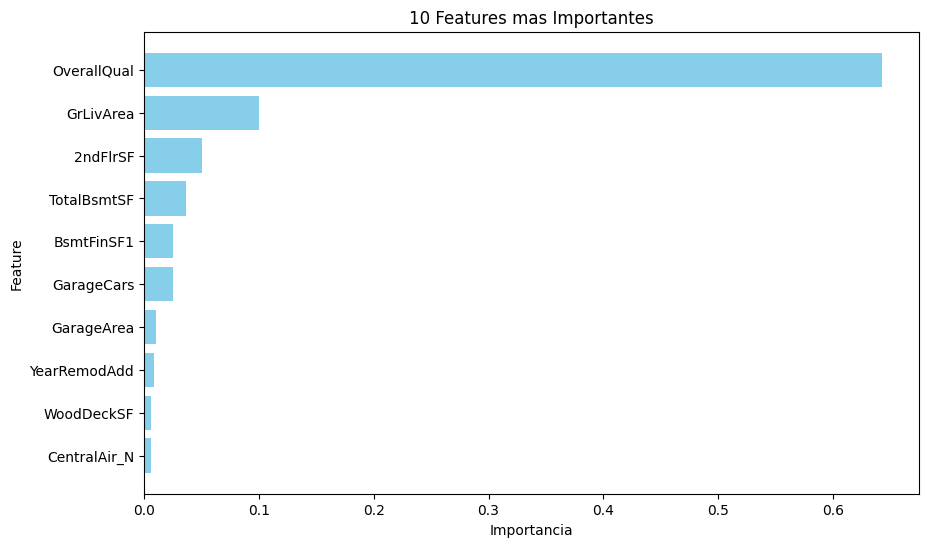

In [324]:
feature_importances = regressor.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

En la gráfica anterior se muestran cuales son las variables que mayor importancia tienen en el modelo.

## Árbol de Regresión (Max Depth = 13) (Inciso 4)
El objetivo principal de esta iteración es evitar el over-fitting, por lo que decidimos cortar la profundidad a la mitad. Esperamos ver un modelo que se adapte mejor a patrones generales, en vez de intentar agrupar cada uno de los datos de entrenamiento dentro de su misma categoría.

### Entrenamiento del Modelo y Predicciones

In [325]:
X_train = train_set_strat.drop(columns=['SalePrice'])
Y_train = train_set_strat['SalePrice']

X_test = test_set_strat.drop(columns=['SalePrice'])
Y_test = test_set_strat['SalePrice']

regressor = DecisionTreeRegressor(random_state = 42, max_depth = 13)

regressor.fit(X_train, Y_train)

Y_pred = regressor.predict(X_test)
Y_train_pred = regressor.predict(X_train)

### Rendimiento del Modelo

In [326]:
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Test")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

mse = mean_squared_error(Y_train, Y_train_pred)
mae = mean_absolute_error(Y_train, Y_train_pred)
r2 = r2_score(Y_train, Y_train_pred)

print("Train")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Test
Mean Squared Error (MSE): 1579257618.6745675
Mean Absolute Error (MAE): 26607.677437110422
R-squared (R²): 0.7607409296024205
Train
Mean Squared Error (MSE): 18179499.717231736
Mean Absolute Error (MAE): 1804.1073953823952
R-squared (R²): 0.9970711241077399


La gran diferencia entre el R² de entrenamiento (0.997) y el R² de prueba (0.76) sugiere un sobreajuste (overfitting). El modelo está ajustándose demasiado a los datos de entrenamiento y no generaliza bien en el conjunto de prueba. Aunque este es menor en conparación con el modelo anteriormente probado.

Reducir la profundidad del árbol puede mejorar la generalización.

### Gráficas

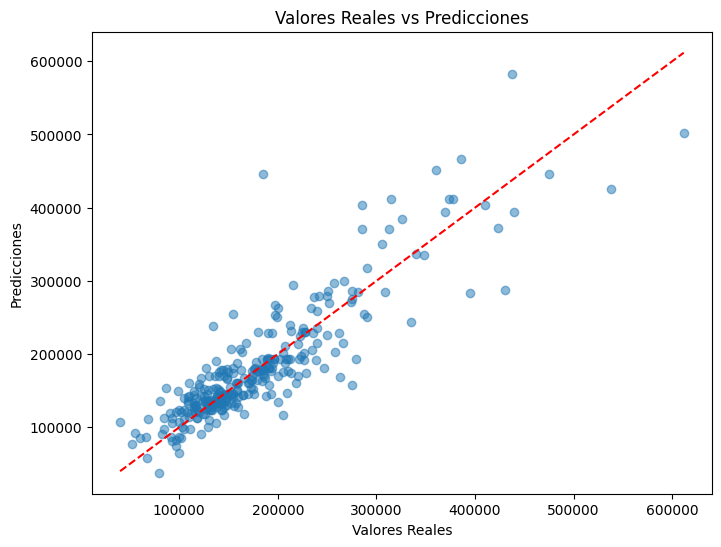

In [327]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.show()

La tendencia general sigue la diagonal esperada, lo que indica que el modelo predice valores relativamente alineados con los reales.
Sin embargo, hay puntos alejados de la línea, lo que muestra errores importantes en algunas predicciones, especialmente cuando se toman valores más grandes del modelo, la dispersión es mayor.

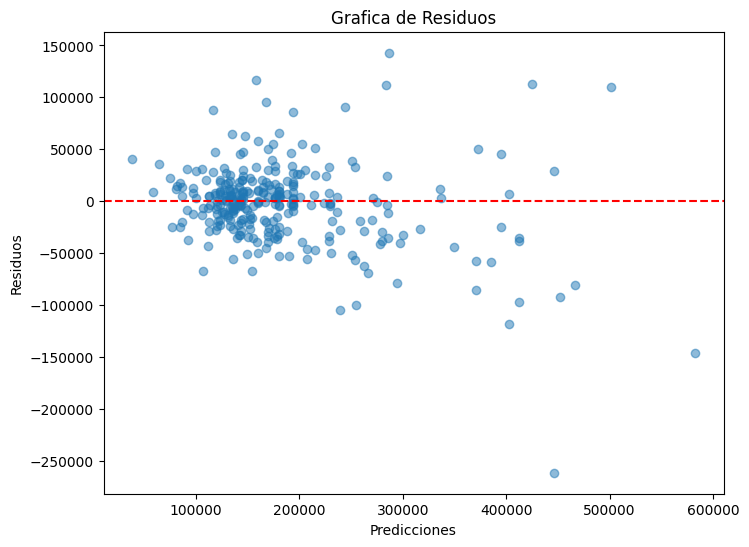

In [328]:
residuals = Y_test - Y_pred

plt.figure(figsize=(8, 6))
plt.scatter(Y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at 0
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Grafica de Residuos")
plt.show()

Distribución dispersa de los residuos sugiere que los errores no siguen un patrón uniforme.
Algunos valores de predicción presentan errores muy altos en ambos sentidos. La dispersión de residuos sugiere que el modelo no captura todas las relaciones correctamente.

## Árbol de Regresión (Max Depth = 4) (Inciso 4)
El objetivo principal de esta iteración es evaluar el performance de los modelos más simples, cómo lo pueden ser árboles con un max_depth significativamente menor a los anteriores.

### Entrenamiento del Modelo y Predicciones

In [329]:
X_train = train_set_strat.drop(columns=['SalePrice'])
Y_train = train_set_strat['SalePrice']

X_test = test_set_strat.drop(columns=['SalePrice'])
Y_test = test_set_strat['SalePrice']

regressor = DecisionTreeRegressor(random_state = 42, max_depth =4)

regressor.fit(X_train, Y_train)

Y_pred = regressor.predict(X_test)
Y_train_pred = regressor.predict(X_train)

### Rendimiento del modelo

In [330]:
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Test")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

mse = mean_squared_error(Y_train, Y_train_pred)
mae = mean_absolute_error(Y_train, Y_train_pred)
r2 = r2_score(Y_train, Y_train_pred)

print("Train")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Test
Mean Squared Error (MSE): 1895453641.8370316
Mean Absolute Error (MAE): 29681.068345619136
R-squared (R²): 0.71283692352344
Train
Mean Squared Error (MSE): 1080556056.9169836
Mean Absolute Error (MAE): 24100.332450985556
R-squared (R²): 0.8259129990062425


La diferencia entre los $R^2$ de train y test es menor, lo cual es positivo porque indica que el modelo está menos sobreajustado, , pero a costa de mayor error en las predicciones.

### Gráficas

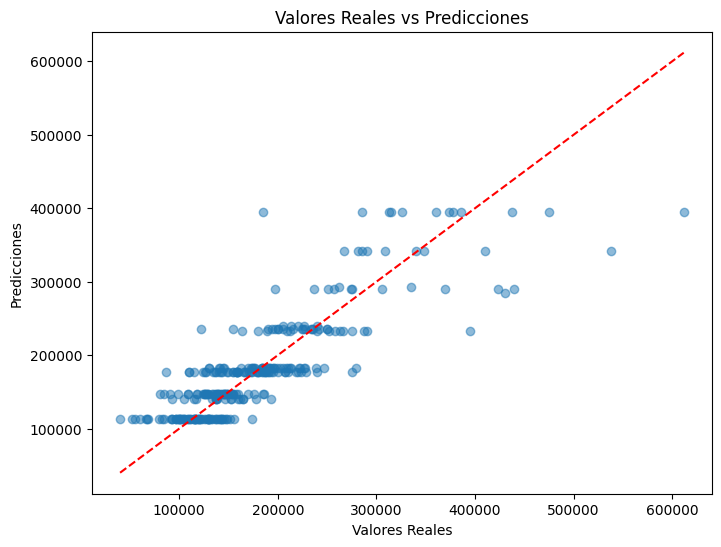

In [331]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.show()

Se observan predicciones discretizadas en niveles, lo que es una característica típica de árboles con poca profundidad.
El modelo no capta bien la variabilidad en los datos, ya que muchas predicciones caen en valores repetitivos.

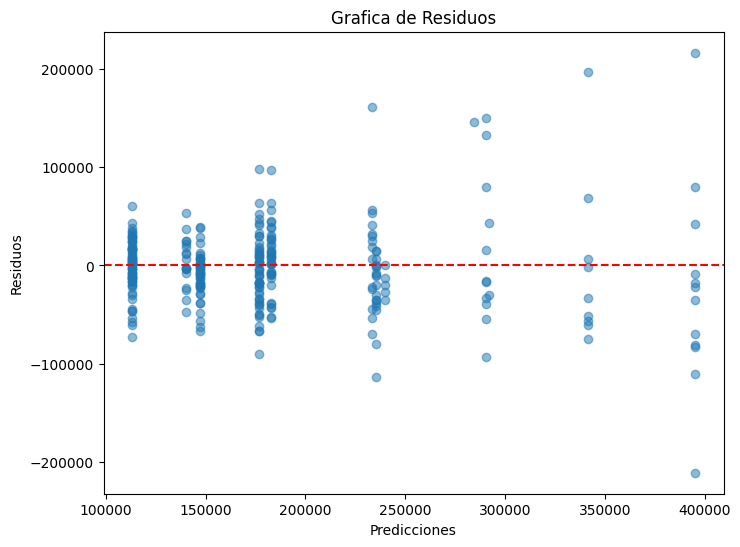

In [332]:
residuals = Y_test - Y_pred

plt.figure(figsize=(8, 6))
plt.scatter(Y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at 0
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Grafica de Residuos")
plt.show()

Se observa patrón estructurado en los residuos, lo que indica que el modelo no captura toda la complejidad de los datos.
Hay grupos de valores bien definidos, lo que sugiere que el árbol no está dividiendo lo suficiente para hacer predicciones más ajustadas.

### Árbol de regresión (Max Depth = X)


## Fine-Tuning (Inciso 4)
El objetivo en esta sección es diseñar un método similar al método del "codo" aplicado en clustering.

*¿Por qué?*

- Conforme aumenta el depth, la precisión del modelo en el conjunto de prueba empieza a llegar a un punto fijo.

- Conforme aumenta el depth, aumenta el overfitting. Dónde se continúa adaptando al conjunto de entrenamiento.

Lo que se busca es encontrar el punto dentro del parámetro de profundidad dónde se deja de ajustar a las características de los datos y empieza a memorizarlos.

*¿Cómo?*

Nuestra propuesta de solución es hacer una gráfica de R2 de prueba y R2 de entrenamiento en comparación al parámetro de max_depth. El objetivo es buscar el punto dónde el R2 de prueba empiece a "aplanarse", similar al codo. Además, podemos validar la efectividad de nuestro método planteado al verificar que el R2 de entrenamiento siga aumentando.

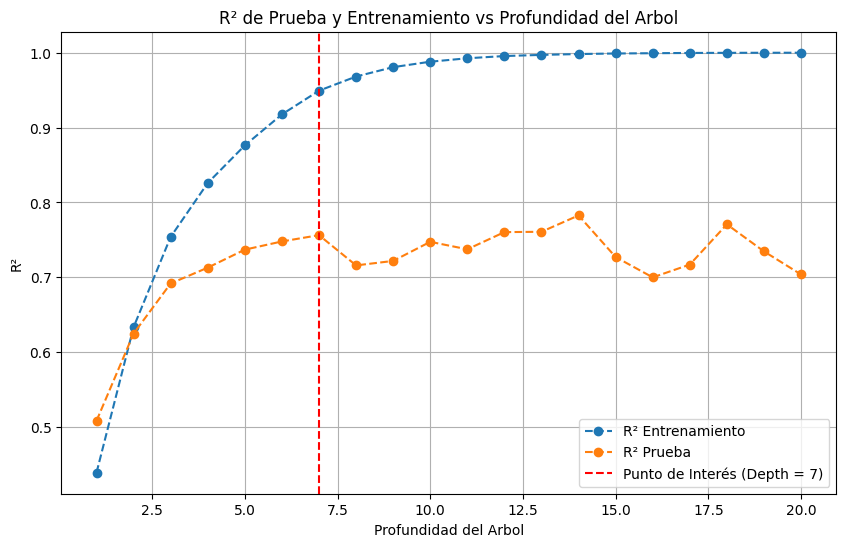

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

depths = range(1, 21)

train_r2 = []
test_r2 = []

for depth in depths:
    regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    regressor.fit(X_train, Y_train)

    Y_train_pred = regressor.predict(X_train)
    train_r2.append(r2_score(Y_train, Y_train_pred))

    Y_test_pred = regressor.predict(X_test)
    test_r2.append(r2_score(Y_test, Y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_r2, marker='o', linestyle='--', label='R² Entrenamiento')
plt.plot(depths, test_r2, marker='o', linestyle='--', label='R² Prueba')
plt.xlabel('Profundidad del Arbol')
plt.ylabel('R²')
plt.title('R² de Prueba y Entrenamiento vs Profundidad del Arbol')
plt.legend()
plt.grid(True)

selected_point = 7
plt.axvline(x=selected_point, color='red', linestyle='--', label=f'Punto de Interés (Depth = {selected_point})')
plt.legend()

plt.show()

*Análisis de la Gráfica*

La gráfica generada es bastante interesante, podemos observar algunos de los siguientes puntos clave:

- Como se predijo, la curva de Training R2 se va aplanando acercándose cada vez más a 1.

- La curva de R2 de entrenamiento parece seguir un trend similar, sin embargo, en contra de las predicciones en lugar de "aplanarse" empieza a tener un comportamiento errático.

*¿Por qué?*

Basados en el análisis realizado anteriormente, sabemos que un mayor ajuste a los datos de entrenamiento puede tener un impacto tanto positivo cómo negativo. Podemos intuir que luego de este punto, el modelo empieza a sobre-ajustar al conjunto de prueba. Luego, la oscilación del modelo puede explicarse cómo un indicador de qué tantas características "pegaron" a los datos de entrenamiento que por "casualidad" fueron seleccionadas en alguna profundidad. Cuándo se empieza a acercar a 1 el R2 de entrenamiento, esto nos indica que únicamente se están dividiendo de manera diferente (basado en diferentes características) los datos y realmente el ajuste con el set de prueba no es un indicador real de la calidad del modelo.

*Solución*

Decidimos utilizar un R2 "cross-validated" para evitar ligeramente la influencia de "casualidades" entre ambos datasets.

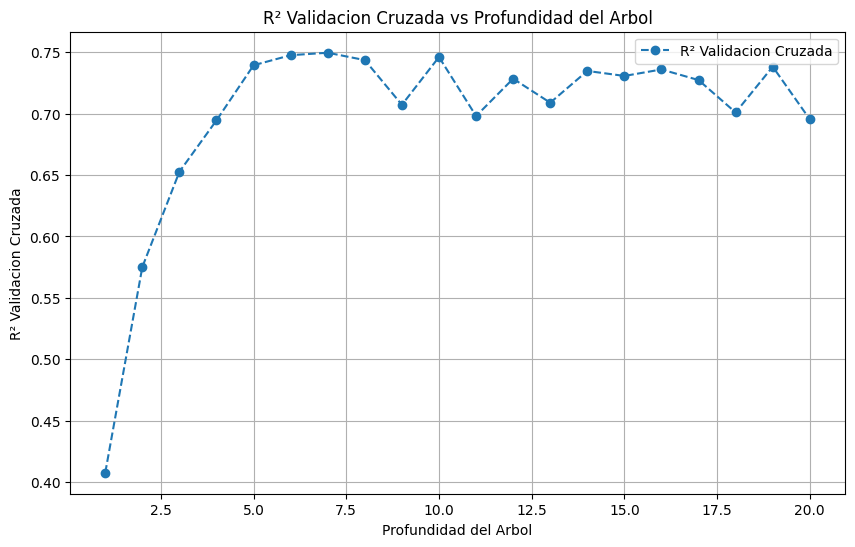

In [334]:
from sklearn.model_selection import cross_val_score

cv_scores = []
for depth in depths:
    regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(regressor, X_train, Y_train, cv=5, scoring='r2')
    cv_scores.append(np.mean(scores))

plt.figure(figsize=(10, 6))
plt.plot(depths, cv_scores, marker='o', linestyle='--', label='R² Validacion Cruzada')
plt.xlabel('Profundidad del Arbol')
plt.ylabel('R² Validacion Cruzada')
plt.title('R² Validacion Cruzada vs Profundidad del Arbol')
plt.legend()
plt.grid(True)
plt.show()

*Análisis de la Gráfica*

En esta gráfica podemos observar que las oscilaciones cambian ligeramente en comparación a la anterior. Esto nos indica que nuestra predicción fue correcta, las oscilaciones simplemente eran causadas por la diferencia en importancia de características en cada  modelo.

*Conclusión*

Debido al comportamiento errático del rendimiento del modelo cuándo las predicciones del conjunto de prueba comienzan a ser perfectas, decidimos buscar minimizar el parámetro de depth para nuestro modelo. Además, buscamos el punto dónde encontremos un mayor valor de R2 con las predicciones del modelo del conjunto de prueba. Por eso, seleccionamos cómo número "óptimo" max_depth = 7.

- Se encuentra antes del comportamiento errático
- Su valor de R2 es similar en el calculado con los conjuntos y cross-validated
- Se maximiza el performance del modelo en comparación a puntos anteriores

## Árbol de Regresión (Max Depth = 7) (Inciso 4)

### Entrenamiento del Modelo y Predicciones

In [335]:
X_train = train_set_strat.drop(columns=['SalePrice'])
Y_train = train_set_strat['SalePrice']

X_test = test_set_strat.drop(columns=['SalePrice'])
Y_test = test_set_strat['SalePrice']

regressor = DecisionTreeRegressor(random_state = 42, max_depth = 7)

regressor.fit(X_train, Y_train)

Y_pred = regressor.predict(X_test)
Y_train_pred = regressor.predict(X_train)

### Rendimiento del modelo

In [336]:
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Test")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

mse = mean_squared_error(Y_train, Y_train_pred)
mae = mean_absolute_error(Y_train, Y_train_pred)
r2 = r2_score(Y_train, Y_train_pred)

print("Train")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

Test
Mean Squared Error (MSE): 1608924998.0470467
Mean Absolute Error (MAE): 25930.851636870815
R-squared (R²): 0.7562462926756415
Train
Mean Squared Error (MSE): 315175541.88056386
Mean Absolute Error (MAE): 13263.798842841314
R-squared (R²): 0.9492224725211224


En comparación con max_depth=4, el modelo con max_depth=7 tiene menor error y mejor ajuste sin sobreajustarse demasiado.
La diferencia entre $R^2$  en entrenamiento y prueba es menor que con max_depth=13, lo que indica mejor generalización.
Aunque aún hay margen de mejora, este modelo parece un buen punto medio entre sobreajuste y subajuste

### Gráficas

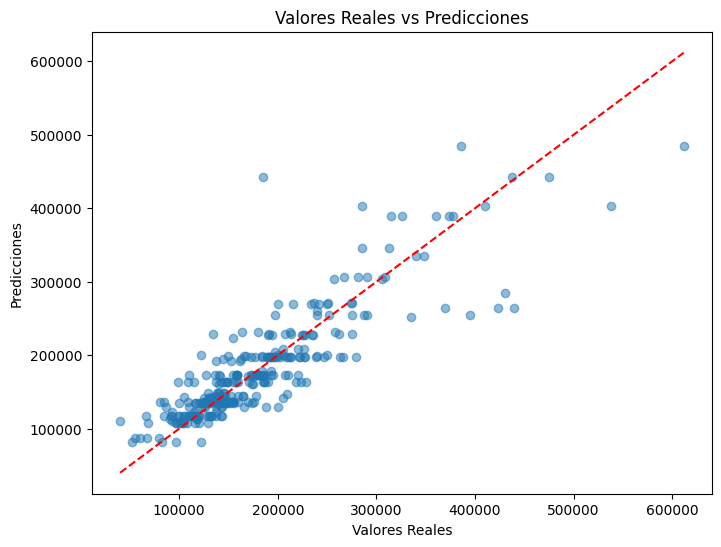

In [337]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.show()

Se puede decir que en este caso se tienen predicciones más ajustadas, sigue existiendo dispersión en valores altos, pero en general, el modelo mejora la aproximación.

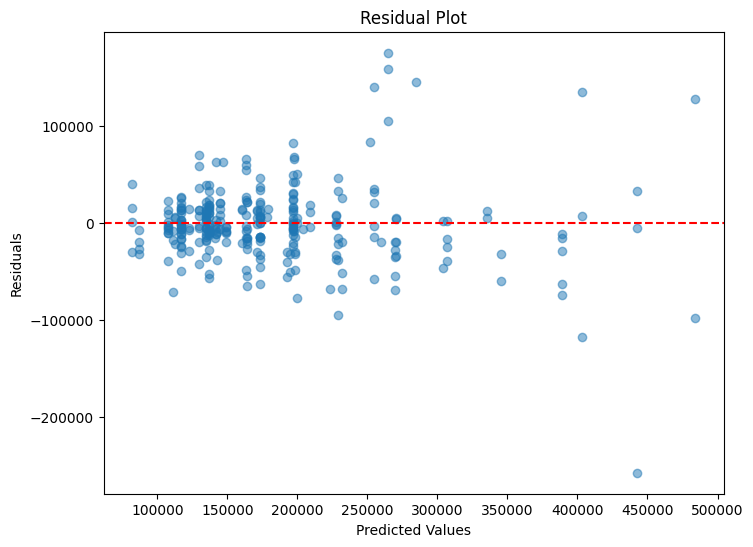

In [338]:
residuals = Y_test - Y_pred

plt.figure(figsize=(8, 6))
plt.scatter(Y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at 0
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

La dispersión en los residuos sigue presente, pero es más balanceada que en max_depth=4, donde había patrones más estructurados.
Aún hay outliers, pero el comportamiento es más uniforme, lo cual indica mejor ajuste del modelo.


## Comparación con Regresión Lineal (Inciso 5)

Tomaremos en cuenta el mejor modelo del la entrega #1 el cual fue el Modelo multivariado, y el de en este caso el modelo con max_depth = 7 el cual fue el que se comportó mejor.

Modelo multivariado:

- R² en entrenamiento: 0.835
- R² en test: 0.790
- MSE en test: 1387721310.02

Árbol de regresión max_depth=7:

Test
- Mean Squared Error (MSE): 1608924998.0470467
- Mean Absolute Error (MAE): 25930.851636870815
- R-squared (R²): 0.7562462926756415

Train
- Mean Squared Error (MSE): 315175541.88056386
- Mean Absolute Error (MAE): 13263.798842841314
- R-squared (R²): 0.9492224725211224

En primer lugar se puede ver que el $R^2$ para el testing fue mejor para el modelo de regresión lineal a pesar de que en el train fue lo contrario. También en el MSE fue menor en el caso del modelo multivariado, lo que ya puede darnos un indicio de qué es mejor para este caso.

Para las gráficas de residuos se puede ver que en el modelo multivariado los datos se agrupan mejor alrededor de 0, viendo cierta tendencia en los puntos, sin embargo, para el árbol de regresión los datos se encuentran más dispersos en el eje y.

Podemos concluir que el modelo multivariado de regresión lineal presenta mejores resultados para el caso estudiado. Esto es porque los árboles de regresión funcionan mejor con variables categóricas y aquí se trabajó con variables numéricas en su mayoría, que se especifican demasiado haciendo que el modelo pierda precisión.

## Creación Variable Respuesta (Inciso 6)

Primero, volvemos a realizar algunas de las gráficas del análisis exploratorio para poder explicar de manera más clara la variable de respuesta. Lo que buscamos es lo siguiente:

- Intermedias: Deben representar la mayoría de las casas, encontrándose cerca del promedio. Siendo la categoría más grande, ya que en una distribución cercana a la normal esto es lo que se espera.


- Económicas y Caras: Representan las casas que se "alejan" de lo que uno podría esperar en cuánto a precio al consultar un dato del dataset. Representan secciones más pequeñas.

[Text(0.5, 1.0, 'Distribucion de SalePrice'),
 Text(0.5, 0, 'Precio de Venta'),
 Text(0, 0.5, 'Cantidad de Casas')]

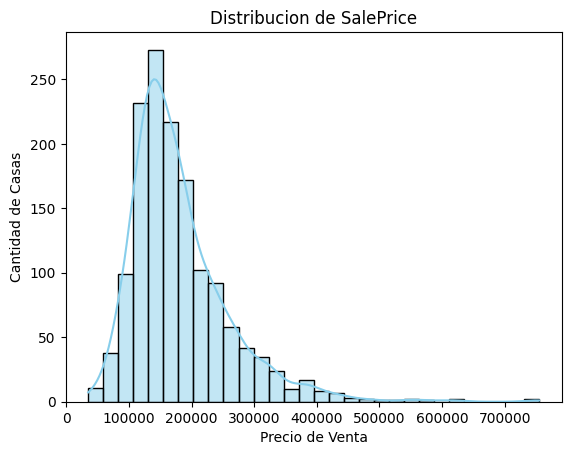

In [339]:
sns.histplot(dftrain['SalePrice'], kde=True, color='skyblue', bins=30).set(title='Distribucion de SalePrice', xlabel='Precio de Venta', ylabel='Cantidad de Casas')

Puntos Clave:

- La distribución tiene densidad máxima entre \$110,000 y \$200,000
- La cantidad de casas a partir de los \$225,000 empieza a declinar significativamente

Buscamos 'separar' las 2 colas de la distribución que siguen los precios de las casas, así obteniendo las casas "económicas" y "caras". Luego, los datos restantes serán las casas "medias".

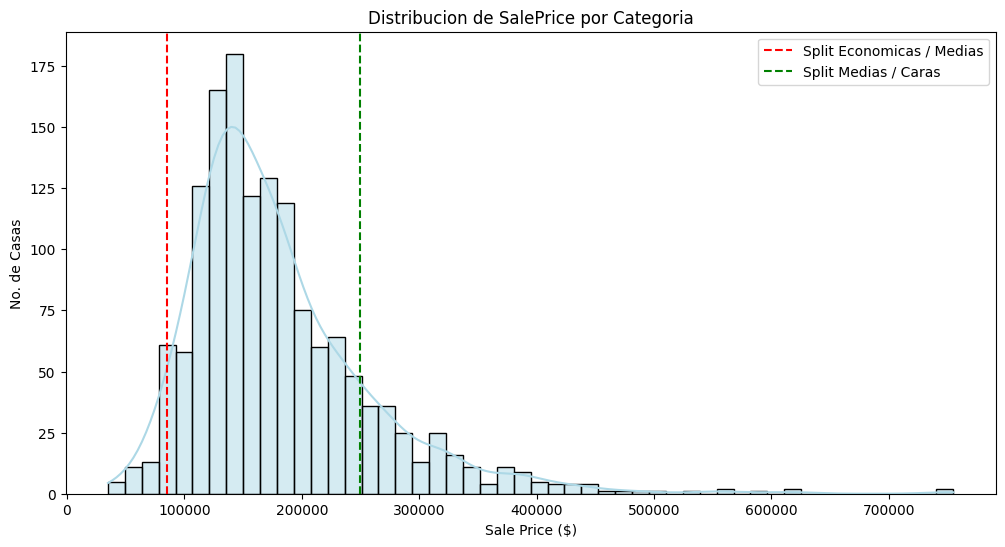

In [340]:
def categorize_price(price):
  if price < 85000:
    return 0
  elif price < 225000:
    return 1
  else:
    return 2

dftrain['PriceCategory'] = dftrain['SalePrice'].apply(categorize_price)

plt.figure(figsize=(12, 6))
sns.histplot(dftrain['SalePrice'], bins=50, kde=True, color="lightblue")

plt.axvline(85000, color='red', linestyle='dashed', label='Split Economicas / Medias')
plt.axvline(250000, color='green', linestyle='dashed', label='Split Medias / Caras')

plt.xlabel("Sale Price ($)")
plt.ylabel("No. de Casas")
plt.title("Distribucion de SalePrice por Categoria")
plt.legend()
plt.show()

Observando la gráfica, podemos ver los splits. Al tener una mayor concentración de datos a la izquierda de la distribución normal, debimos realizar un corte más "cercano" al promedio en comparación al lado derecho. Sin embargo, observamos que nuestra interpretación de la distribución fue adecuada y logramos separar las colas de la mayoría de los valores que se encuentran cercanos a la media.

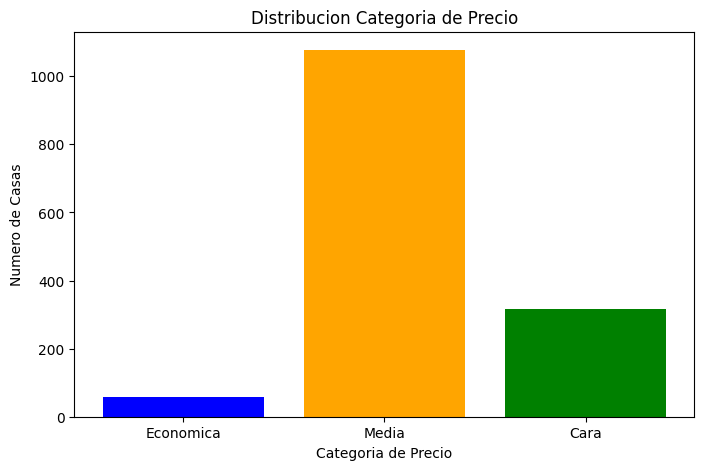

In [341]:
category_counts = dftrain['PriceCategory'].value_counts().sort_index()

category_labels = ['Economica', 'Media', 'Cara']

plt.figure(figsize=(8, 5))
plt.bar(category_labels, category_counts, color=['blue', 'orange', 'green'])
plt.xlabel("Categoria de Precio")
plt.ylabel("Numero de Casas")
plt.title("Distribucion Categoria de Precio")
plt.show()

Observando la distribución, nos podemos dar cuenta que existen más casas caras que económicas. Esto se debe a la distribución que sigue el SalePrice y el skewness. Simplemente adecuamos la separación de categorías a la distribución

## Árbol de Clasifcación (Incisos 7, 8, 9)


Primero, tomamos nuestros splits de entrenamiento y prueba para agregar la nueva variable categórica de respuesta y remover SalePrice

In [342]:
train_categorized = train_set_strat.copy(deep=True)
test_categorized = test_set_strat.copy(deep=True)

train_categorized['PriceCategory'] = train_categorized['SalePrice'].apply(categorize_price)
test_categorized['PriceCategory'] = test_categorized['SalePrice'].apply(categorize_price)

X_train = train_categorized.drop(columns=['SalePrice', 'PriceCategory'])
Y_train = train_categorized['PriceCategory']

X_test = test_categorized.drop(columns=['SalePrice', 'PriceCategory'])
Y_test = test_categorized['PriceCategory']

Luego creamos nuestro árbol, y lo entrenamos con el conjunto de entrenamiento

In [343]:
clf = DecisionTreeClassifier(random_state=42, max_depth = 3)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [344]:
Y_pred = clf.predict(X_test)

Luego de obtener las predicciones, podemos realizar la matriz de confusión que nos indica la precisión del modelo

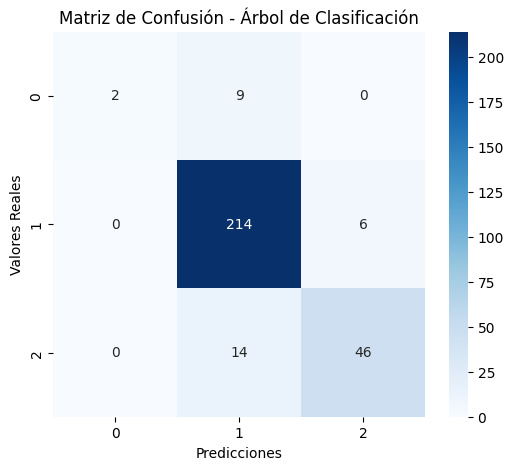

In [345]:
# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)

# Definir etiquetas de clases
class_labels = clf.classes_

# Crear el heatmap con Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión - Árbol de Clasificación")
plt.show()

La matriz de confusión nos indica que el modelo es bastante efectivo, sin embargo hay algunos puntos clave que se pueden resaltar:

- Las casas económicas no son detectadas con una precisión muy alta, esto puede darse debido a la poca cantidad de casas económicas dentro del dataset. Se podría solucionar utilizando un dataset más grande o ampliando la distribución de casas económicas

- Las casas "medias" se detectan con una precisión sumamente alta, únicamente siendo confundidas con las caras en 6/220 ocasiones. Esto nos indica que hay una clara distinción entre ambos "bordes" de la variable y el modelo pudo ser entrenado correctamente

- Las casas "caras" se detectan con una precisión bastante alta, sin embargo suelen ser confundidas con las casas "medias".

Conclusion

El modelo es efectivo detectando casas "medias", sin embargo existe algo de confusión al intentar identificar casas "caras" o "economicas". Esto puede darse por el tamaño de muestra para entrenar al modelo, dónde una selección más pequeña genera menos "distinción" para estas categorías.

In [346]:
print("\nReporte de Clasificación:\n", classification_report(Y_test, Y_pred))


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.90      0.97      0.94       220
           2       0.88      0.77      0.82        60

    accuracy                           0.90       291
   macro avg       0.93      0.64      0.69       291
weighted avg       0.90      0.90      0.89       291



Según el reporte de clasificación, el modelo tuvo una precisión sumamente alta. Sin embargo, vale la pena resaltar que la mayoría de casas caen dentro de "intermedias" y este número no cuenta la historia completa. Ya que, por ejemplo, las casas "económicas" tuvieron un recall de 0.18.

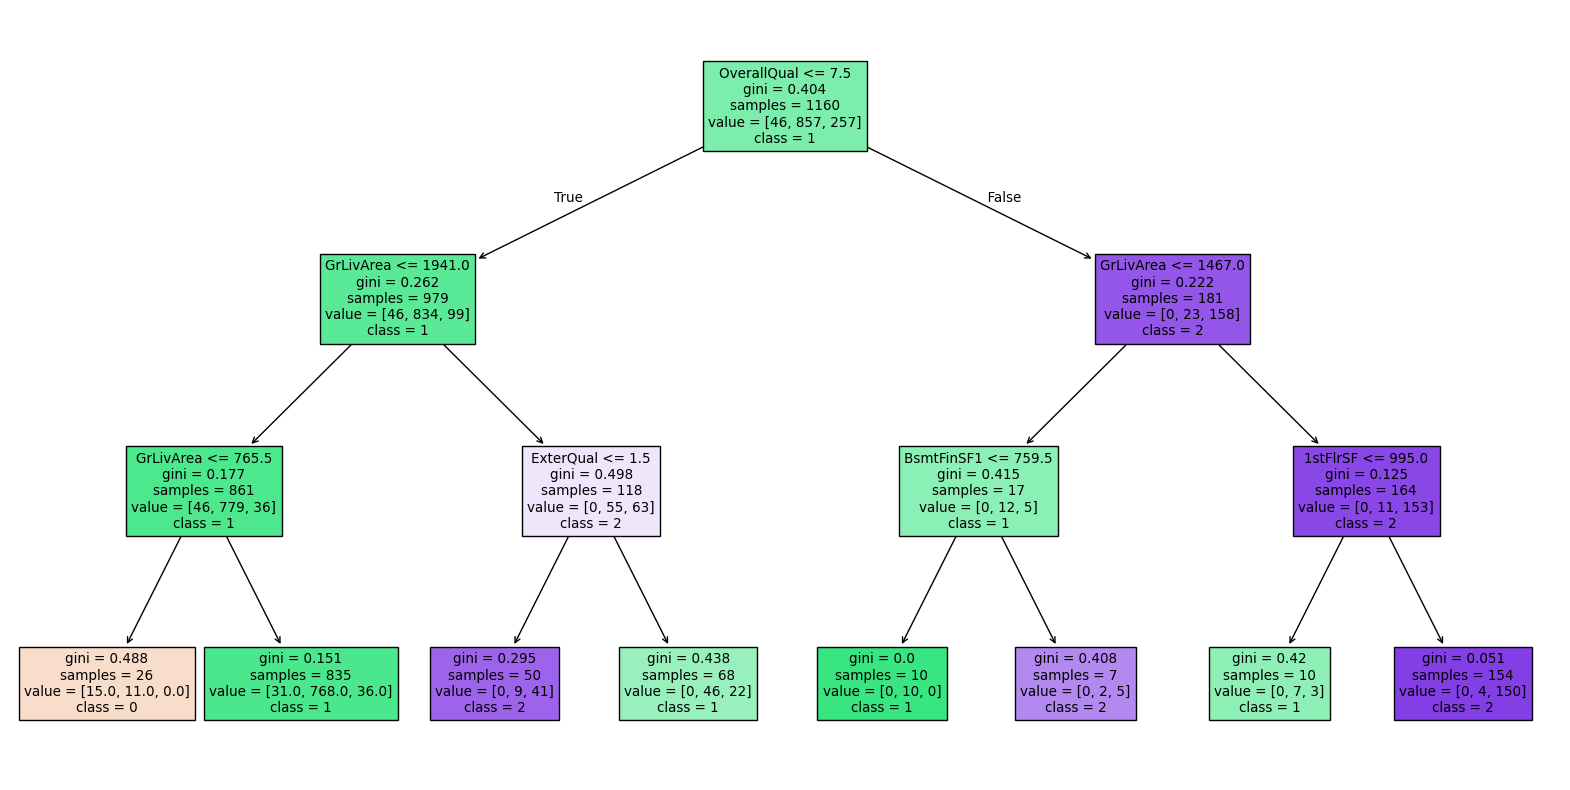

In [347]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=[str(c) for c in clf.classes_])
plt.show()

## Validación Cruzada (Inciso 10)

El objetivo en esta sección es utilizar validación cruzada para realizar "tuning" del parámetro de profundidad del árbol.

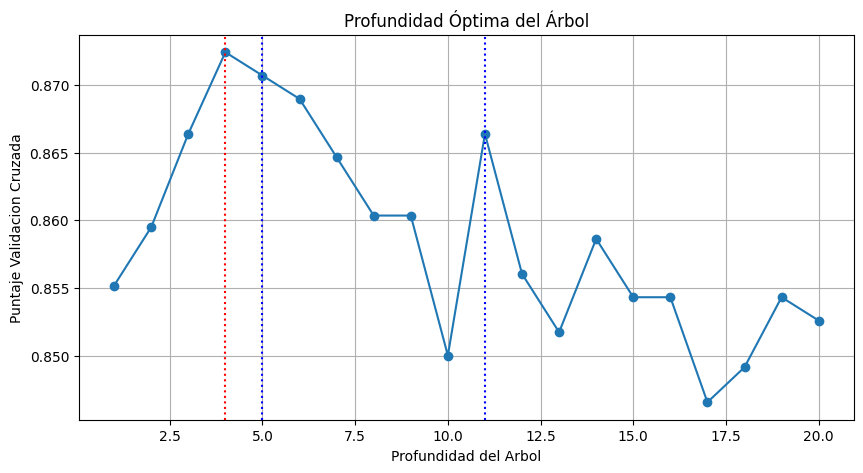

In [348]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

max_depths = range(1, 21)
scores = []

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    score = np.mean(cross_val_score(clf, X_train, Y_train, cv=5))
    scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(max_depths, scores, marker='o', linestyle='-')
plt.axvline(x=4, color='red', linestyle='dotted')
plt.axvline(x=5, color='blue', linestyle='dotted')
plt.axvline(x=11, color='blue', linestyle='dotted')
plt.xlabel('Profundidad del Arbol')
plt.ylabel('Puntaje Validacion Cruzada')
plt.title('Profundidad Óptima del Árbol')
plt.grid()
plt.show()

Esta gráfica nos indica cómo varía el puntaje de precisión según cambia la profundidad del árbol, a pesar que todos los puntajes sean relativamente buenos y se encuentren cercanos el uno al otro podemos tomar algunos puntos de interés para los siguientes árboles

## Arbol de Clasificacion (Max_Depth = 4) (Inciso 11)



In [349]:
clf = DecisionTreeClassifier(random_state=42, max_depth = 4)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

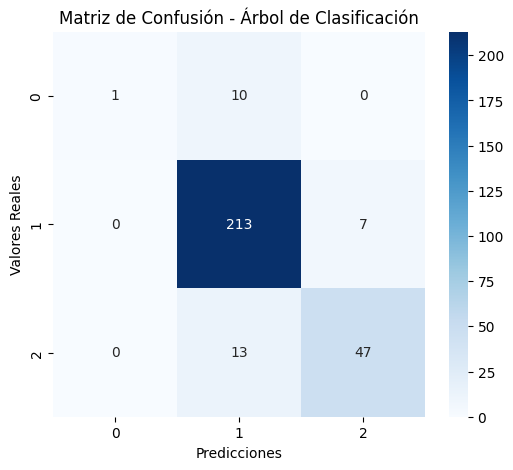


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.90      0.97      0.93       220
           2       0.87      0.78      0.82        60

    accuracy                           0.90       291
   macro avg       0.92      0.61      0.64       291
weighted avg       0.90      0.90      0.88       291



In [350]:
# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)

# Definir etiquetas de clases
class_labels = clf.classes_

# Crear el heatmap con Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión - Árbol de Clasificación")
plt.show()

print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

Parecido a la distribución original, parece tener un performance súmamente bueno para la categoría de "media" y "cara". Sin embargo, sigue siendo difícil que el modelo logre identificar las casas "económicas". Por esto, decidimos explorar los demás puntos de interés con parámetros de profundidad más altos. Buscando un modelo más adecuado que se ajuste a la información que tenemos.

## Arbol de Clasificacion (Max_Depth = 5) (Inciso 11)


In [351]:
clf = DecisionTreeClassifier(random_state=42, max_depth = 5)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

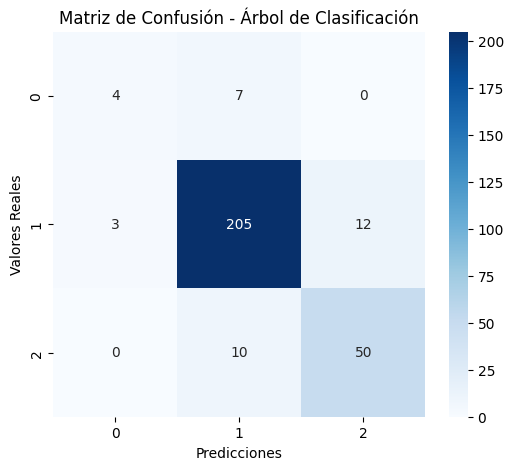


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.92      0.93      0.93       220
           2       0.81      0.83      0.82        60

    accuracy                           0.89       291
   macro avg       0.77      0.71      0.73       291
weighted avg       0.89      0.89      0.89       291



In [352]:
# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)

# Definir etiquetas de clases
class_labels = clf.classes_

# Crear el heatmap con Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión - Árbol de Clasificación")
plt.show()

print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

La matriz de confusión, al igual que el reporte de clasificación nos indican que al aumentar la profundidad del árbol parece reconocer mejor las estratificaciones más pequeñas. Sin embargo, empezamos a notar más errores en cuánto a confusiones dentro de las casas "intermedias" y "económicas". Decidimos seguir explorando los demás puntos de interés con un mayor parámetro de profundidad para seguir explorando esta relación.

## Arbol de Clasificacion (Max_Depth = 11) (Inciso 11)


In [353]:
clf = DecisionTreeClassifier(random_state=42, max_depth = 11)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

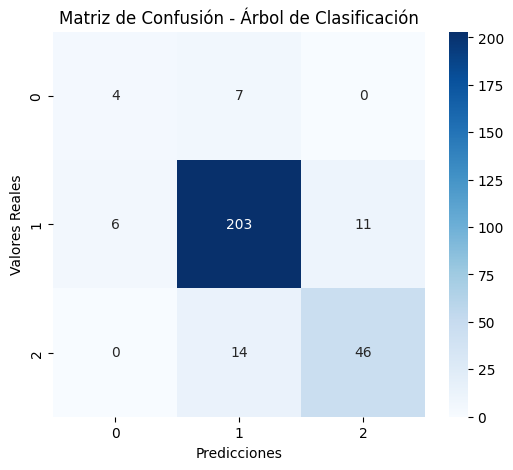


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.91      0.92      0.91       220
           2       0.81      0.77      0.79        60

    accuracy                           0.87       291
   macro avg       0.70      0.68      0.69       291
weighted avg       0.87      0.87      0.87       291



In [354]:
# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, y_pred)

# Definir etiquetas de clases
class_labels = clf.classes_

# Crear el heatmap con Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión - Árbol de Clasificación")
plt.show()

print("\nReporte de Clasificación:\n", classification_report(Y_test, y_pred))

En este modelo podemos notar que la precisión en las estratificaciones más pequeñas no aumentó, mientras que en general decreció. Esto nos indica que hubo un sobre-ajuste con los datos de entrenamiento, dónde el modelo ya no es capaz de acoplarse a información nueva.

## Random Forest (Inciso 12)


In [355]:
from sklearn.ensemble import RandomForestRegressor

In [356]:
X_train = train_set_strat.drop(columns=['SalePrice'])
Y_train = train_set_strat['SalePrice']

X_test = test_set_strat.drop(columns=['SalePrice'])
Y_test = test_set_strat['SalePrice']

In [357]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 7)
rf_regressor.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, random_state=42)

In [358]:
Y_pred = rf_regressor.predict(X_test)

In [359]:
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 1180850274.326254
Mean Absolute Error (MAE): 19937.165202
R-squared (R²): 0.821100


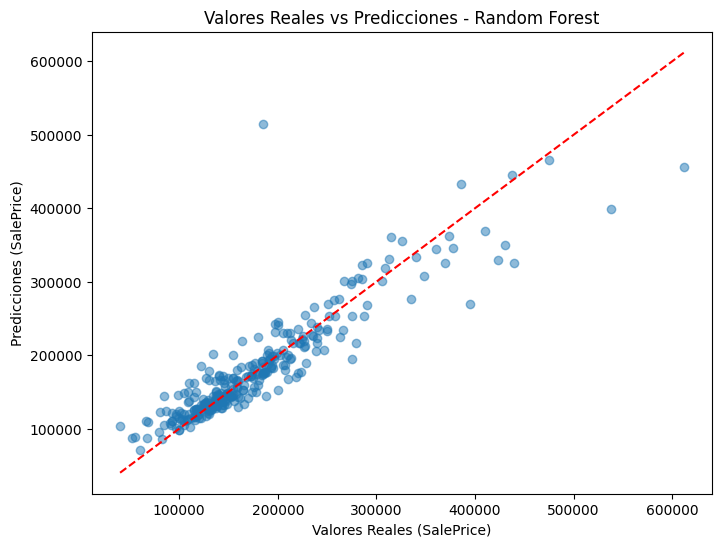

In [360]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Línea de referencia
plt.xlabel("Valores Reales (SalePrice)")
plt.ylabel("Predicciones (SalePrice)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

La mayoría de los puntos están cerca de la línea roja, lo que indica una buena precisión general. Aunque para precios altos se observan algunos puntos alejados de la línea en el extremo superior derecho, sugiriendo que el modelo tiene más dificultad para predecir precios muy altos. Esto podría indicar la necesidad de ajustar parametros o aumentar la profundidad del árbol o el número de estimadores.

<ipython-input-361-6195b188b511>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_importances, y=top_5_features, palette="viridis")


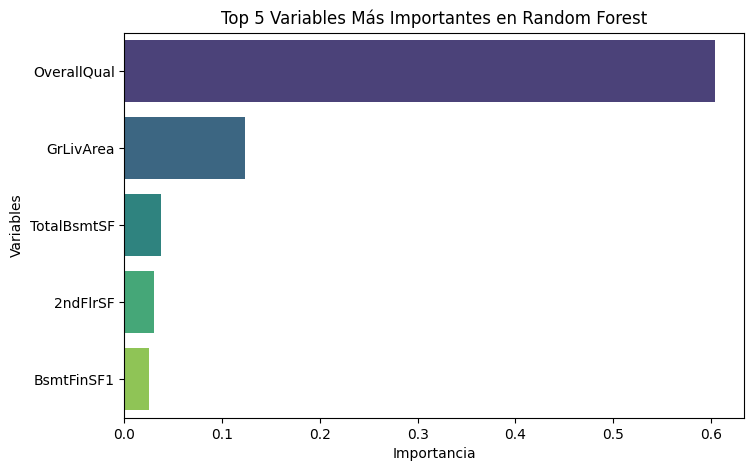

In [361]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_regressor.feature_importances_
features = X_train.columns

sorted_indices = np.argsort(importances)[::-1]  # Sort in descending order
top_5_indices = sorted_indices[:5]  # Get the top 5 indices

top_5_importances = importances[top_5_indices]
top_5_features = features[top_5_indices]

plt.figure(figsize=(8, 5))
sns.barplot(x=top_5_importances, y=top_5_features, palette="viridis")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.title("Top 5 Variables Más Importantes en Random Forest")
plt.show()

Esta gráfica va acorde a lo que sabemos actualmente de nuestro dataset, y se alinea con las demás regresiones que hemos aplicado anteriormente.

Probando una variación de parámetros utilizando Random Forest, con n=1000

In [362]:
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state = 42, max_depth = 7)
rf_regressor.fit(X_train, Y_train)
Y_pred = rf_regressor.predict(X_test)

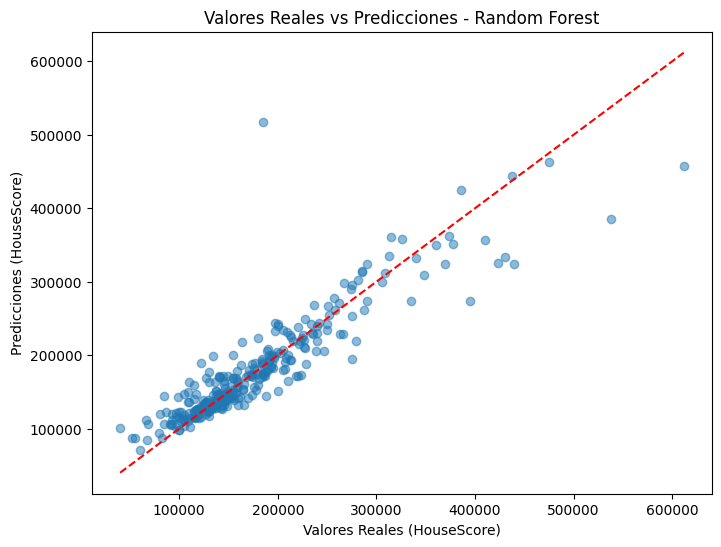

In [363]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--')  # Línea de referencia
plt.xlabel("Valores Reales (HouseScore)")
plt.ylabel("Predicciones (HouseScore)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

Seguimos teniendo dificultades para precios altos los puntos a destacar son:

La mayoría de los puntos están cercanos a la línea roja, lo que sugiere que el modelo tiene un rendimiento razonablemente bueno.
Hay cierta dispersión, especialmente en valores más altos (predicciones por encima de 400,000), lo que indica que el modelo pierde precisión con valores extremos.
Se observan algunos outliers donde las predicciones están notablemente por debajo o por encima de la línea ideal.

In [364]:
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 1202058878.841008
Mean Absolute Error (MAE): 19817.219985
R-squared (R²): 0.817887


## Análisis de Resultados

### Árboles de Regresión
Los árboles de regresión probaron ser una herramienta súmamente útil, la distribución entre datos de prueba y entrenamiento comprobó ser un problema. En algunos casos, algunos modelos con una mayor / menor profundidad no seguían el patrón que nosotros esperamos. Los puntajes dentro de prueba variaban significativamente sin seguir un patrón definido, y estos cambiaban cuando se realizaba una validación cruzada. Concluímos lo siguiente:

- El árbol de regresión suele sufrir de over-fitting al tener una profundidad muy alta, por ende es recomendado intentar minimizar este parámetro.

- La validación cruzada es un método de análisis sumamente importante para intentar evaluar estas regresiones, ya que la importancia de los features puede sesgar los datos dependiendo de la distribución de datos de entremiento / prueba.

- En el caso de este dataset, no probaron ser más efectivos que una regresión lineal. Esto puede ser debido a que las estratificaciones que realizan son muy, o muy poco específicas.

- Un árbol de clasificación podría ser una herramienta más útil

### Clasificación
Los árboles de clasificación tuvieron un alto rendimiento, sin embargo consideramos que pueden ser más útiles en variables que sigan una distribución normal. Esto debido a que, por falta de datos de entrenamiento para ciertas categorías, parece no poder realizar predicciones precisas para estratos más pequeños. Al aumentar la profundidad, estos árboles suelen "mezclar" más los datos. Concluímos lo siguiente:

- Los árboles de decisión nos fueron más útiles para esta variable categórica en vez de la variable numérica utilizada en el árbol de regresión

- Es sumamente importante tener en cuenta la cantidad de datos de entrenamiento, ya que al no ser suficientes puede que el modelo no sea efectivo

- Un depth muy alto puede causar que se "mezclen" más las categorías

- Un depth muy bajo puede causar que las categorías menos populares tengan un reconocimiento súmamente bajo.

### Random Forest
El algoritmo de Random Forest para un árbol de regresión resultó ser el más adecuado hasta el momento. Esto puede darse ante relaciones no-lineales que estos modelos logran representar de manera adecuada. Además, utilizando la profundidad más adecuada que encontramos explorando los árboles de regresión logramos un excelente rendimiento. Adicionalmente, el variar el parámetro de n=100 a n=1000 nos dió un rendimiento similar y no dió mejores resultados. Concluímos lo siguiente:

- Random Forest ha sido el modelo más adecuado hasta el momento

- Algunas de las relaciones entre las variables pueden ser no lineales, y se capturan mejor en este tipo de modelos.

- La exploración de árboles previo a utilizar Random Forest nos dió un "head-start" encontrando parámetros óptimos

- No necesariamente tener un n más grande aumenta la efectividad del modelo

### Comparación con Otros Algoritmos
En comparación a las regresiones lineales, el rendimiento de Random Forest fue superior. Obtuvimos un R² en entrenamiento de 0.82 en comparación a 0.79 del modelo lineal multivariado. Además, observando las gráficas de "predicción vs datos reales" podemos darnos cuenta que los puntos están mucho más cercanos a la línea ideal. Esto nos quiere decir que Random Forest puede predecir con mucha precisión, sin embargo sigue siendo sensible a los outliers dentro del dataset.